In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json

# Severe imbalance dataset: analyze the 54 mortality cases performance

In [14]:
patient_path = "/data/wang/junh/githubs/Debate/KARE/data/ehr_data/mimic3_mortality_samples_test.json"
base_path_rag = "/data/wang/junh/githubs/Debate/KARE/results/rag"

- Which patient always been predicted wrong?

In [15]:
# For all 996 patient ids, count the wrong predictions made by each model based on log in each folder under base_path_rag
# The kare_debate_mortality_results.json under each folder contains the prediction results for all 996 patients

# Load patient data to get ground truth
with open(patient_path, 'r') as f:
    patient_data = json.load(f)

# Create a dictionary for quick lookup of ground truth by patient_id
patient_gt = {}
for patient in patient_data:
    key = f"{patient['patient_id']}_{patient['visit_id']}"
    patient_gt[key] = patient['label']

# Get all model directories
model_dirs = [d for d in os.listdir(base_path_rag) if os.path.isdir(os.path.join(base_path_rag, d))]

# Analyze wrong predictions for each model
model_errors = {}
patient_error_counts = {}  # Track which patients are always wrong

for model_dir in model_dirs:
    results_file = os.path.join(base_path_rag, model_dir, 'kare_debate_mortality_results.json')
    
    if not os.path.exists(results_file):
        print(f"Skipping {model_dir} - no results file found")
        continue
    
    with open(results_file, 'r') as f:
        results = json.load(f)
    
    # Count wrong predictions
    wrong_predictions = []
    for result in results['results']:
        patient_id = result['patient_id']
        prediction = result['prediction']
        ground_truth = result['ground_truth']
        
        if prediction != ground_truth:
            wrong_predictions.append(patient_id)
            
            # Track patient error counts across models
            if patient_id not in patient_error_counts:
                patient_error_counts[patient_id] = []
            patient_error_counts[patient_id].append(model_dir)
    
    model_errors[model_dir] = {
        'total_errors': len(wrong_predictions),
        'wrong_patient_ids': wrong_predictions,
        'accuracy': 1 - len(wrong_predictions) / len(results['results'])
    }

# Display results
print("=" * 80)
print("WRONG PREDICTIONS BY MODEL")
print("=" * 80)
for model, errors in model_errors.items():
    print(f"\n{model}:")
    print(f"  Total Errors: {errors['total_errors']}")
    print(f"  Accuracy: {errors['accuracy']:.4f}")

# Find patients that are always predicted wrong
print("\n" + "=" * 80)
print("PATIENTS ALWAYS PREDICTED WRONG (by all models)")
print("=" * 80)

always_wrong = []
for patient_id, error_models in patient_error_counts.items():
    if len(error_models) == len(model_dirs):
        always_wrong.append(patient_id)
        print(f"Patient {patient_id}: Wrong in all {len(error_models)} models")

print(f"\nTotal patients always wrong: {len(always_wrong)}")

WRONG PREDICTIONS BY MODEL

rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_format_enforcer_7b_step57_MedCPT_8_8:
  Total Errors: 87
  Accuracy: 0.9127

fallback_rag_mor_Qwen_Qwen2.5_7B_Instruct_8_8:
  Total Errors: 167
  Accuracy: 0.8323

rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8:
  Total Errors: 54
  Accuracy: 0.9458

rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_both_format_enforcer_7b_step57_MedCPT_8_8:
  Total Errors: 85
  Accuracy: 0.9147

rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_unlabel_7b_step150_MedCPT_8_8:
  Total Errors: 907
  Accuracy: 0.0894

PATIENTS ALWAYS PREDICTED WRONG (by all models)
Patient 3977_2: Wrong in all 5 models

Total patients always wrong: 1


- Whether re-try triggered because of none, and for which patient?

In [16]:
# For all 996 patient ids, screen the debate_logs folder under each folder in base_path_rag
# Analyze retry and fallback for ALL models

import re

def check_for_fallback(log_path):
    """
    Check if a log file has fallback predictions (missing mortality or survival probabilities).
    Based on analyze_fallback_predictions.py logic.
    """
    try:
        with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()
        
        # Extract probabilities from INTEGRATOR section only
        mortality_pattern = r'EXTRACTED MORTALITY PROBABILITY[:\s]+([0-9.]+)'
        survival_pattern = r'EXTRACTED SURVIVAL PROBABILITY[:\s]+([0-9.]+)'
        
        mortality_matches = re.findall(mortality_pattern, content)
        survival_matches = re.findall(survival_pattern, content)
        
        # Use the last (final) probabilities after any retries
        has_valid_mortality = len(mortality_matches) > 0
        has_valid_survival = len(survival_matches) > 0
        
        # Check if extraction was successful
        extraction_success = has_valid_mortality and has_valid_survival
        is_fallback = not extraction_success
        
        return {
            'has_valid_mortality': has_valid_mortality,
            'has_valid_survival': has_valid_survival,
            'is_fallback': is_fallback,
            'mortality_prob': float(mortality_matches[-1]) if mortality_matches else None,
            'survival_prob': float(survival_matches[-1]) if survival_matches else None,
            'num_mortality_extractions': len(mortality_matches),
            'num_survival_extractions': len(survival_matches)
        }
    except Exception as e:
        return {
            'has_valid_mortality': False,
            'has_valid_survival': False,
            'is_fallback': True,
            'mortality_prob': None,
            'survival_prob': None,
            'num_mortality_extractions': 0,
            'num_survival_extractions': 0
        }

retry_analysis = {}
all_retry_patients = {}  # patient_id -> list of models where retry occurred

# Get all model directories
model_dirs = [d for d in os.listdir(base_path_rag) if os.path.isdir(os.path.join(base_path_rag, d))]

for model_name in model_dirs:
    model_path = os.path.join(base_path_rag, model_name)
    debate_logs_path = os.path.join(model_path, 'debate_logs')
    
    if not os.path.exists(debate_logs_path):
        continue
    
    # Use shortened model name for display
    model_display = model_name
    if len(model_name) > 80:
        model_display = '...' + model_name[-65:]
    
    fallback_patients = []
    retry_patients = []
    
    # Get all log files
    log_files = [f for f in os.listdir(debate_logs_path) if f.startswith('debate_responses_') and f.endswith('.log')]
    
    for log_file in log_files:
        log_path = os.path.join(debate_logs_path, log_file)
        patient_id = log_file.replace('debate_responses_', '').replace('.log', '')
        
        # Check for fallback (None probabilities in integrator)
        fallback_info = check_for_fallback(log_path)
        
        if fallback_info['is_fallback']:
            fallback_patients.append({
                'patient_id': patient_id,
                'has_mortality': fallback_info['has_valid_mortality'],
                'has_survival': fallback_info['has_valid_survival'],
                'mortality_prob': fallback_info['mortality_prob'],
                'survival_prob': fallback_info['survival_prob']
            })
        
        # Retry = when number of extractions > 1 (initial attempt + retry)
        has_retry = (fallback_info['num_mortality_extractions'] > 1 or 
                     fallback_info['num_survival_extractions'] > 1)
        
        if has_retry:
            retry_patients.append({
                'patient_id': patient_id,
                'mortality_extractions': fallback_info['num_mortality_extractions'],
                'survival_extractions': fallback_info['num_survival_extractions'],
                'mortality_retries': max(0, fallback_info['num_mortality_extractions'] - 1),
                'survival_retries': max(0, fallback_info['num_survival_extractions'] - 1)
            })
            
            # Track across models
            if patient_id not in all_retry_patients:
                all_retry_patients[patient_id] = []
            all_retry_patients[patient_id].append(model_display)
    
    retry_analysis[model_display] = {
        'total_fallback': len(fallback_patients),
        'missing_mortality_only': len([p for p in fallback_patients if not p['has_mortality'] and p['has_survival']]),
        'missing_survival_only': len([p for p in fallback_patients if p['has_mortality'] and not p['has_survival']]),
        'missing_both': len([p for p in fallback_patients if not p['has_mortality'] and not p['has_survival']]),
        'total_retries': len(retry_patients),
        'fallback_details': fallback_patients,
        'retry_details': retry_patients
    }

# Print summary
print("=" * 80)
print("FALLBACK AND RETRY ANALYSIS SUMMARY")
print("=" * 80)

for model_name, analysis in retry_analysis.items():
    print(f"\n{model_name}:")
    print(f"  Fallback predictions: {analysis['total_fallback']}")
    print(f"    - Missing mortality only: {analysis['missing_mortality_only']}")
    print(f"    - Missing survival only: {analysis['missing_survival_only']}")
    print(f"    - Missing both: {analysis['missing_both']}")
    print(f"  Patients with retries: {analysis['total_retries']}")

# Find patients with retries across multiple models
print("\n" + "=" * 80)
print("PATIENTS WITH RETRIES ACROSS MULTIPLE MODELS")
print("=" * 80)

sorted_retry_patients = sorted(all_retry_patients.items(), key=lambda x: len(x[1]), reverse=True)

if len(sorted_retry_patients) > 0:
    print(f"Total patients with retries: {len(sorted_retry_patients)}\n")
    
    # Show patients with retries in multiple models
    multi_model_retries = [(pid, models) for pid, models in sorted_retry_patients if len(models) > 1]
    
    if len(multi_model_retries) > 0:
        print(f"Patients with retries in MULTIPLE models ({len(multi_model_retries)} patients):")
        for patient_id, models in multi_model_retries[:20]:  # Show first 20
            print(f"  Patient {patient_id}: retries in {len(models)} models")
        
        if len(multi_model_retries) > 20:
            print(f"  ... and {len(multi_model_retries) - 20} more patients with multiple-model retries")
    else:
        print("No patients with retries in multiple models.")
    
    # Retry frequency distribution
    print(f"\nRetry frequency distribution:")
    retry_counts = {}
    for pid, models in sorted_retry_patients:
        count = len(models)
        retry_counts[count] = retry_counts.get(count, 0) + 1
    
    for count in sorted(retry_counts.keys(), reverse=True):
        print(f"  {retry_counts[count]} patients with retries in {count} model(s)")
else:
    print("No patients with retries found across all models.")


FALLBACK AND RETRY ANALYSIS SUMMARY

...junh_Debate_KARE_verl_models_format_enforcer_7b_step57_MedCPT_8_8:
  Fallback predictions: 16
    - Missing mortality only: 13
    - Missing survival only: 3
    - Missing both: 0
  Patients with retries: 74

fallback_rag_mor_Qwen_Qwen2.5_7B_Instruct_8_8:
  Fallback predictions: 152
    - Missing mortality only: 91
    - Missing survival only: 56
    - Missing both: 5
  Patients with retries: 4

...nh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8:
  Fallback predictions: 2
    - Missing mortality only: 0
    - Missing survival only: 2
    - Missing both: 0
  Patients with retries: 21

...Debate_KARE_verl_models_both_format_enforcer_7b_step57_MedCPT_8_8:
  Fallback predictions: 9
    - Missing mortality only: 3
    - Missing survival only: 5
    - Missing both: 1
  Patients with retries: 30

...e_KARE_verl_models_prediction_brier_unlabel_7b_step150_MedCPT_8_8:
  Fallback predictions: 2
    - Missing mortality only: 0
    - Missing

- Distribution of survival and mortality probabilities -- inconsistency?

Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_format_enforcer_7b_step57_MedCPT_8_8...
Processing fallback_rag_mor_Qwen_Qwen2.5_7B_Instruct_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_both_format_enforcer_7b_step57_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_both_format_enforcer_7b_step57_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_unlabel_7b_step150_MedCPT_8_8...

INVALID PROBABILITIES DETECTED (> 1.0)

rag_mor_Qwen_Qwen2.5_7B_Instruct_in

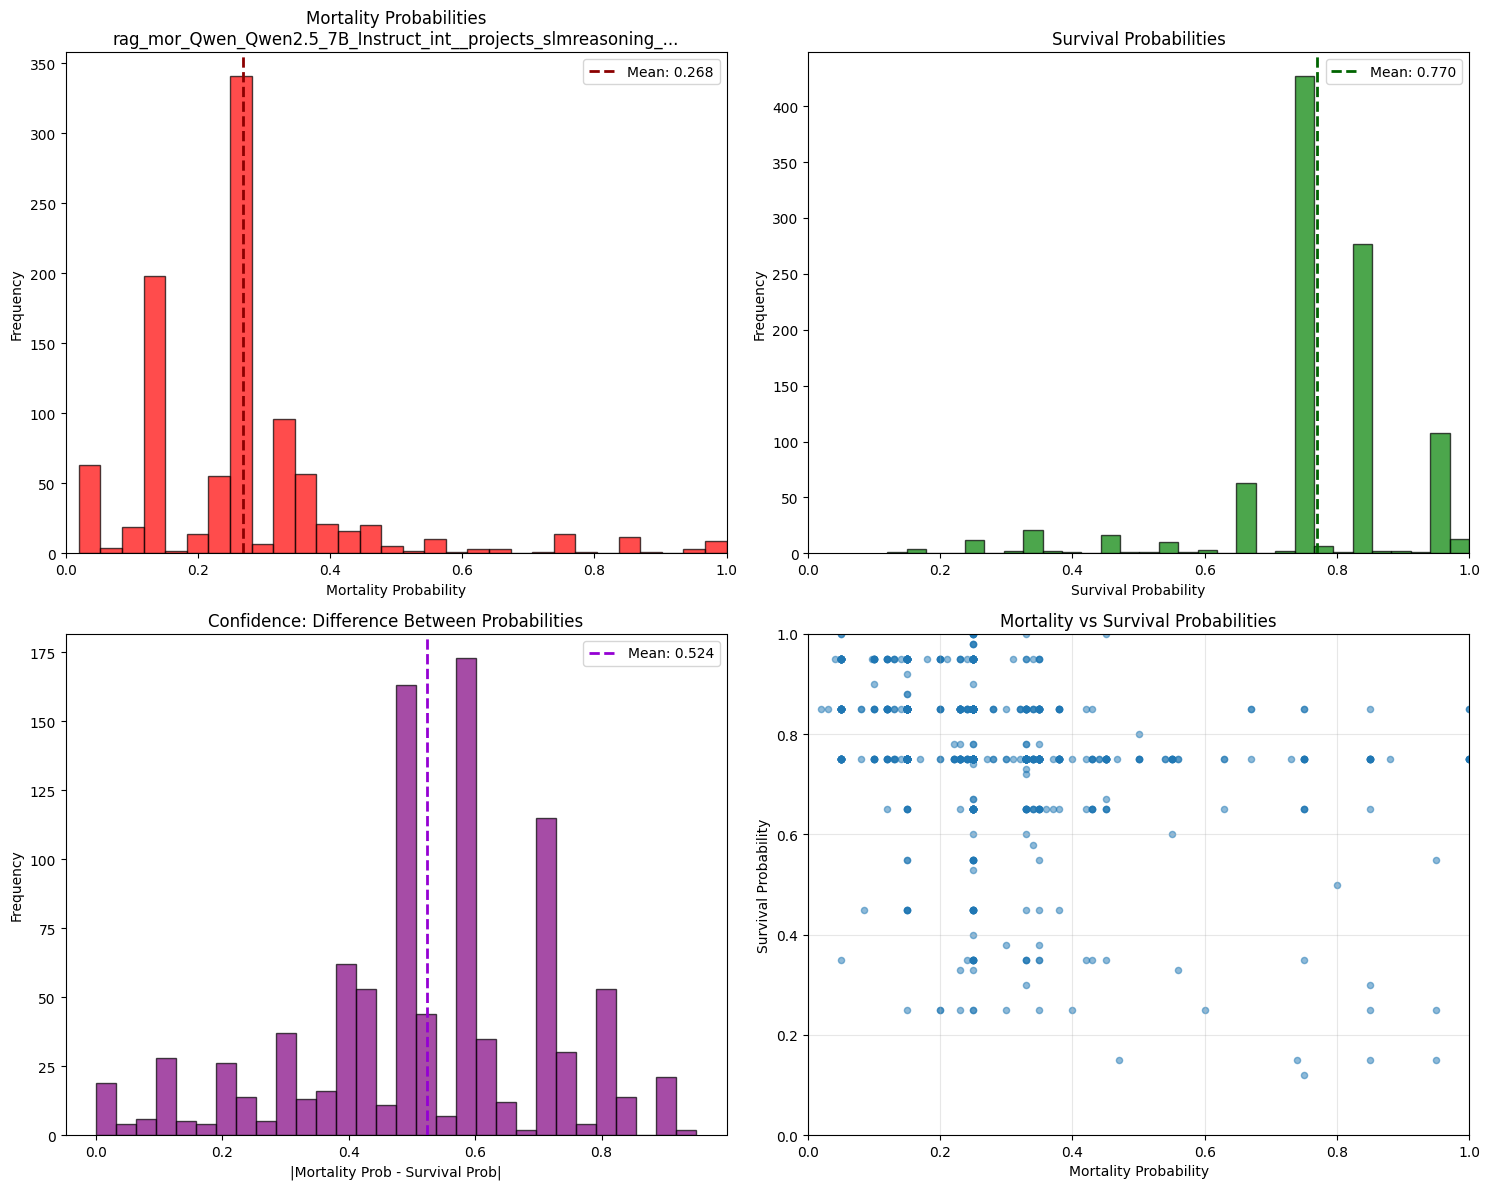


PROBABILITY STATISTICS
Mortality Probability - Mean: 0.2678, Std: 0.1622
Survival Probability - Mean: 0.7703, Std: 0.1406
Confidence (|diff|) - Mean: 0.5240, Std: 0.1956
High confidence (|diff| > 0.5): 512 (52.35%)
Low confidence (|diff| < 0.2): 73 (7.46%)

MODEL: fallback_rag_mor_Qwen_Qwen2.5_7B_Instruct_8_8
Valid probability pairs: 843


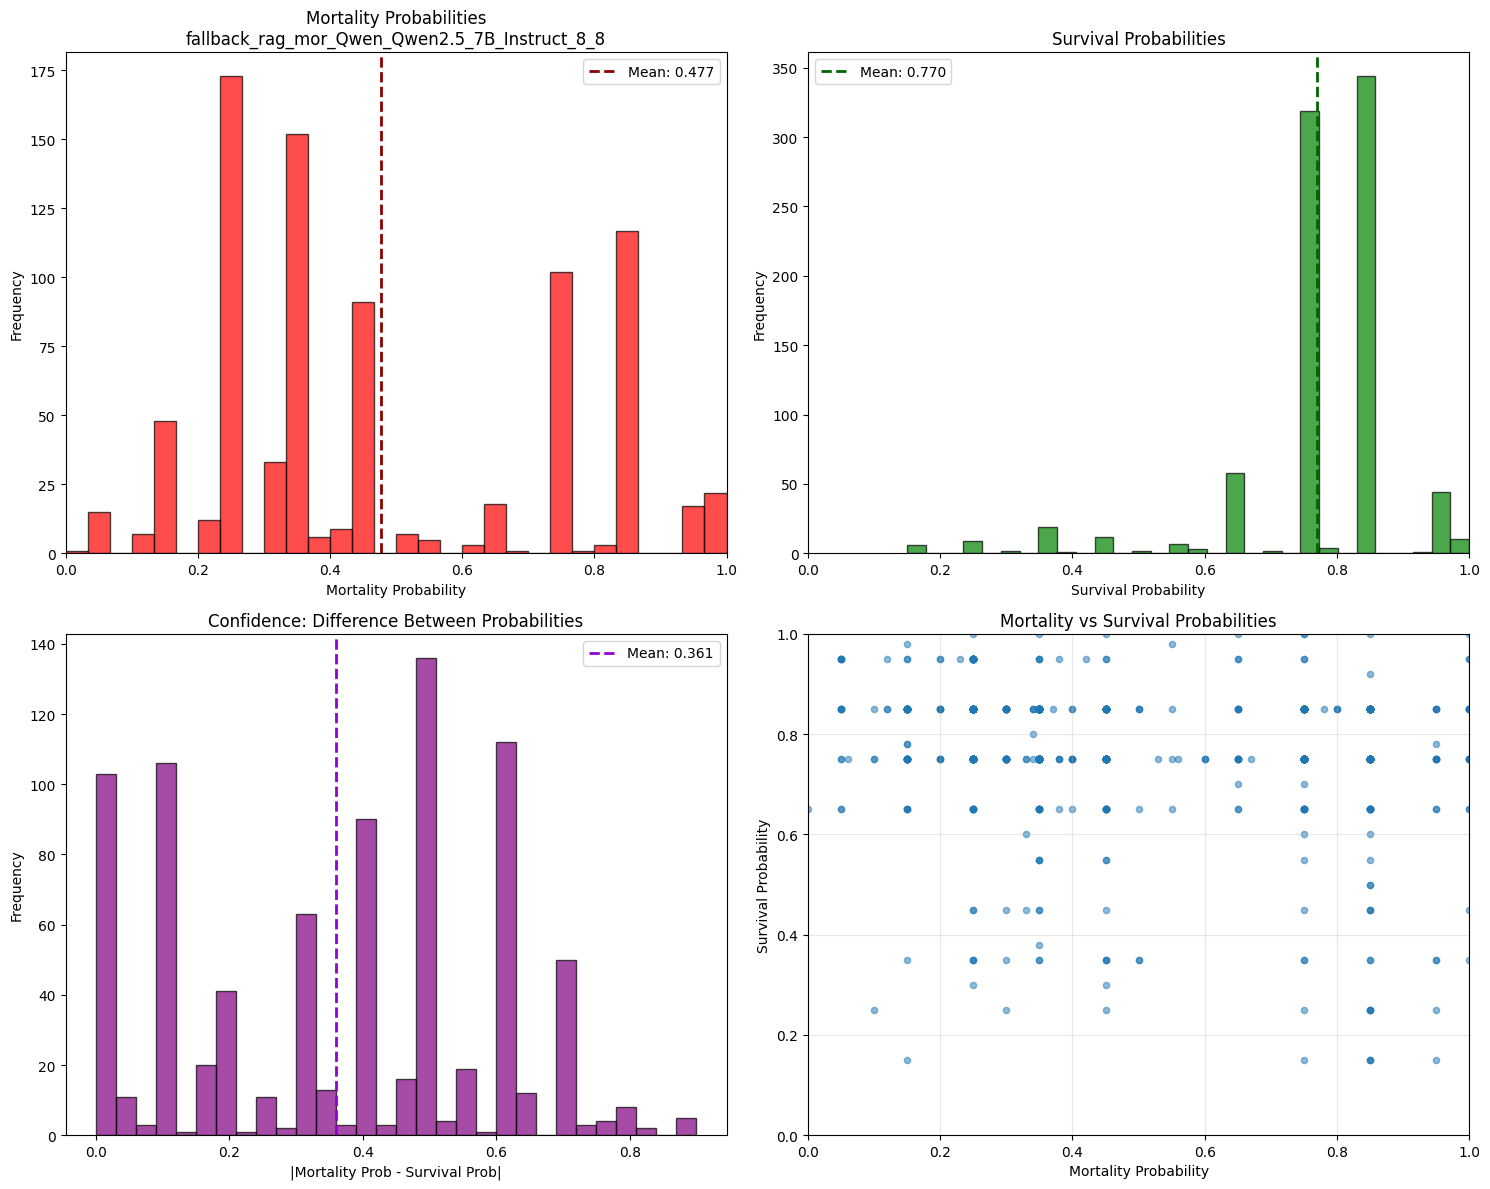


PROBABILITY STATISTICS
Mortality Probability - Mean: 0.4770, Std: 0.2608
Survival Probability - Mean: 0.7703, Std: 0.1362
Confidence (|diff|) - Mean: 0.3606, Std: 0.2329
High confidence (|diff| > 0.5): 220 (26.10%)
Low confidence (|diff| < 0.2): 270 (32.03%)

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8
Valid probability pairs: 966


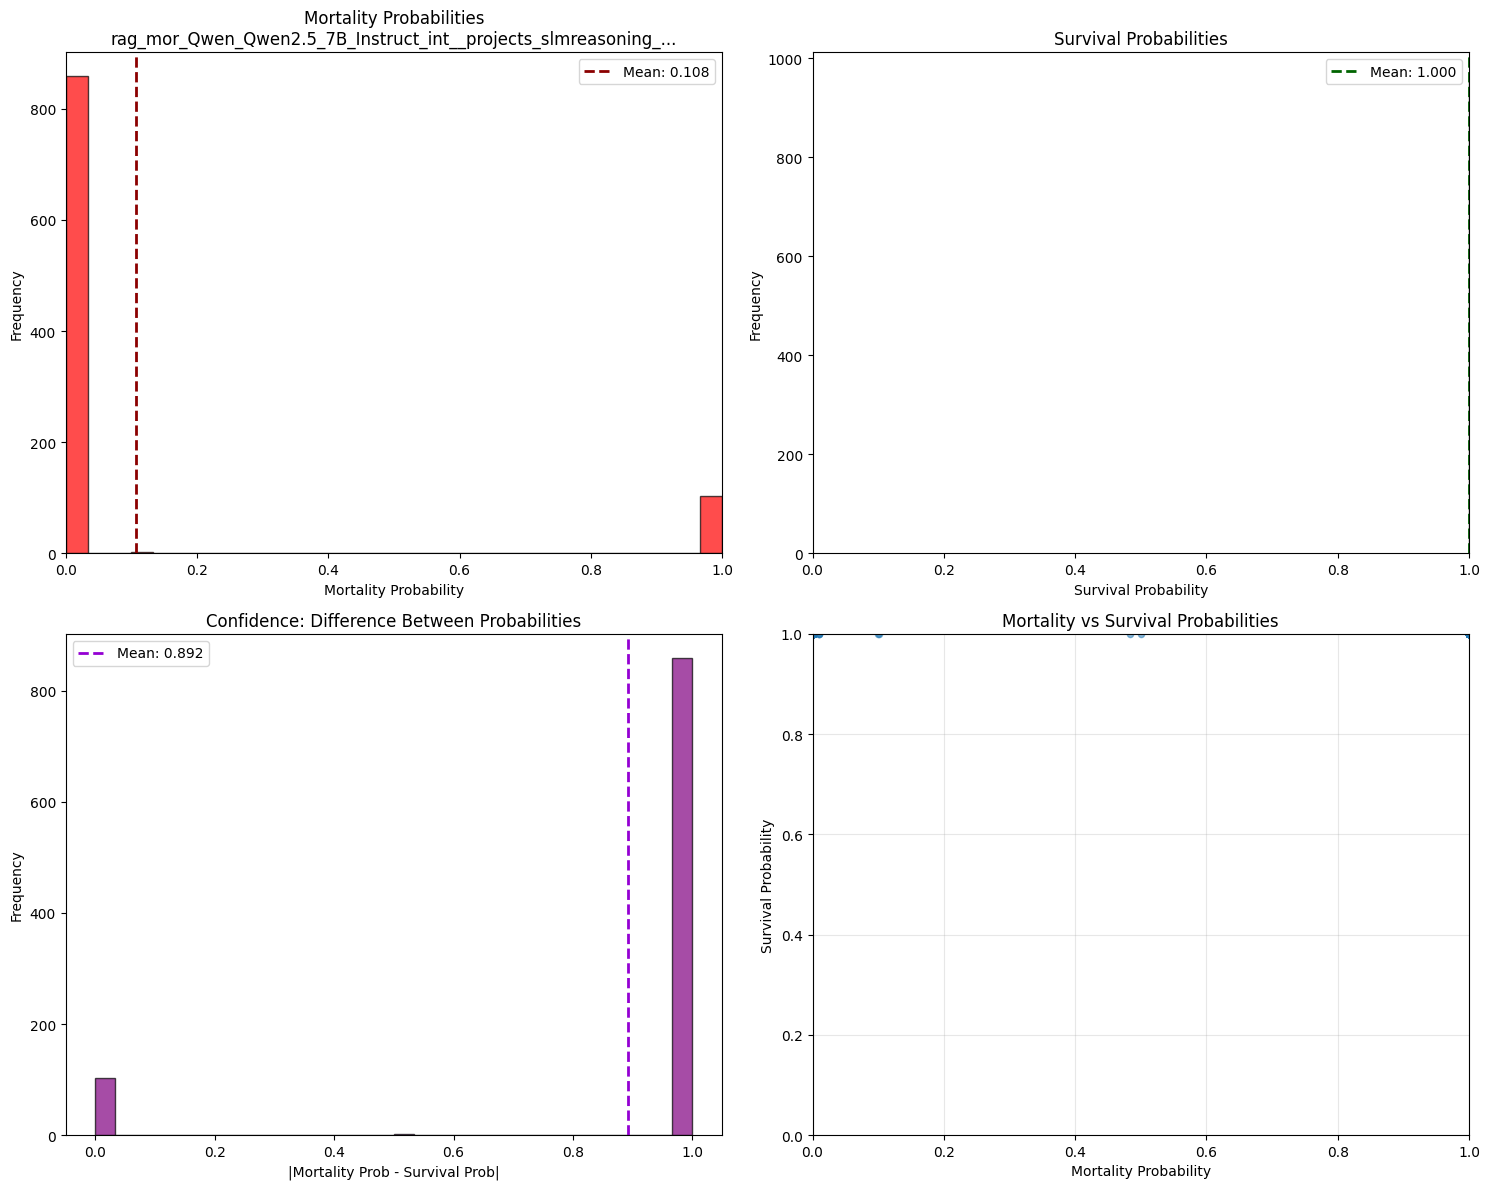


PROBABILITY STATISTICS
Mortality Probability - Mean: 0.1079, Std: 0.3092
Survival Probability - Mean: 1.0000, Std: 0.0000
Confidence (|diff|) - Mean: 0.8921, Std: 0.3092
High confidence (|diff| > 0.5): 862 (89.23%)
Low confidence (|diff| < 0.2): 103 (10.66%)

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_both_format_enforcer_7b_step57_MedCPT_8_8
Valid probability pairs: 987


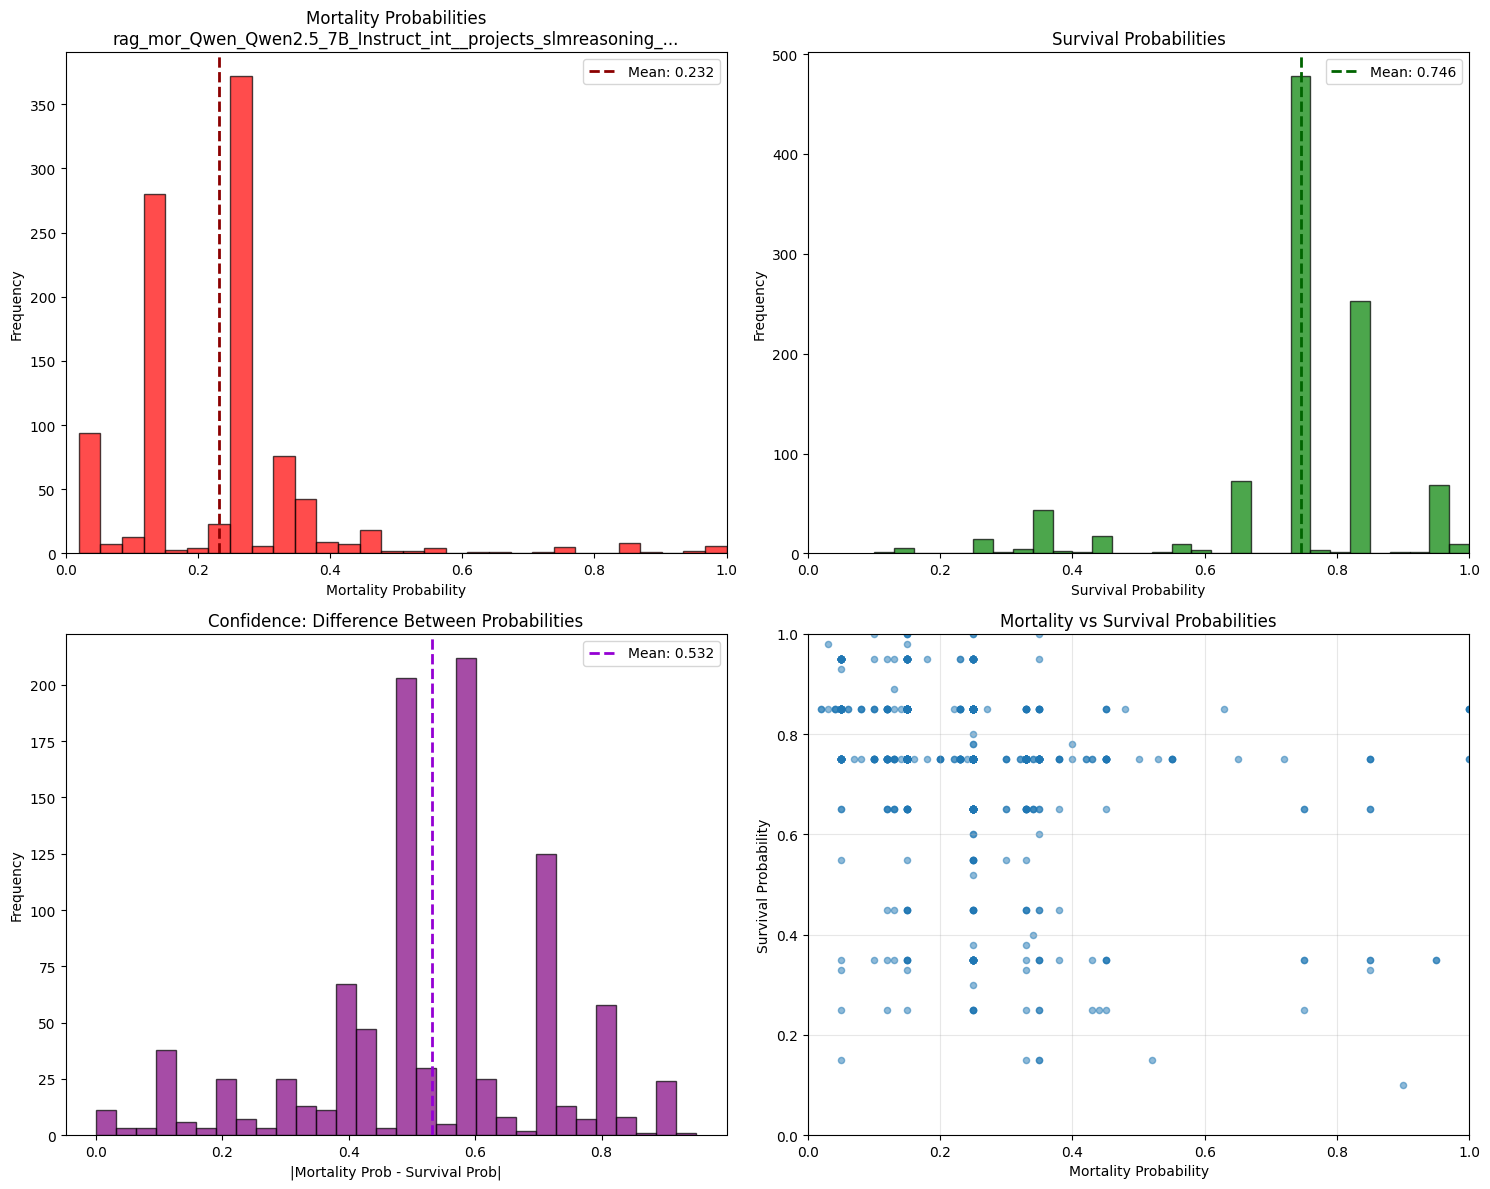


PROBABILITY STATISTICS
Mortality Probability - Mean: 0.2317, Std: 0.1395
Survival Probability - Mean: 0.7457, Std: 0.1510
Confidence (|diff|) - Mean: 0.5323, Std: 0.1877
High confidence (|diff| > 0.5): 519 (52.58%)
Low confidence (|diff| < 0.2): 77 (7.80%)

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_unlabel_7b_step150_MedCPT_8_8
Valid probability pairs: 36


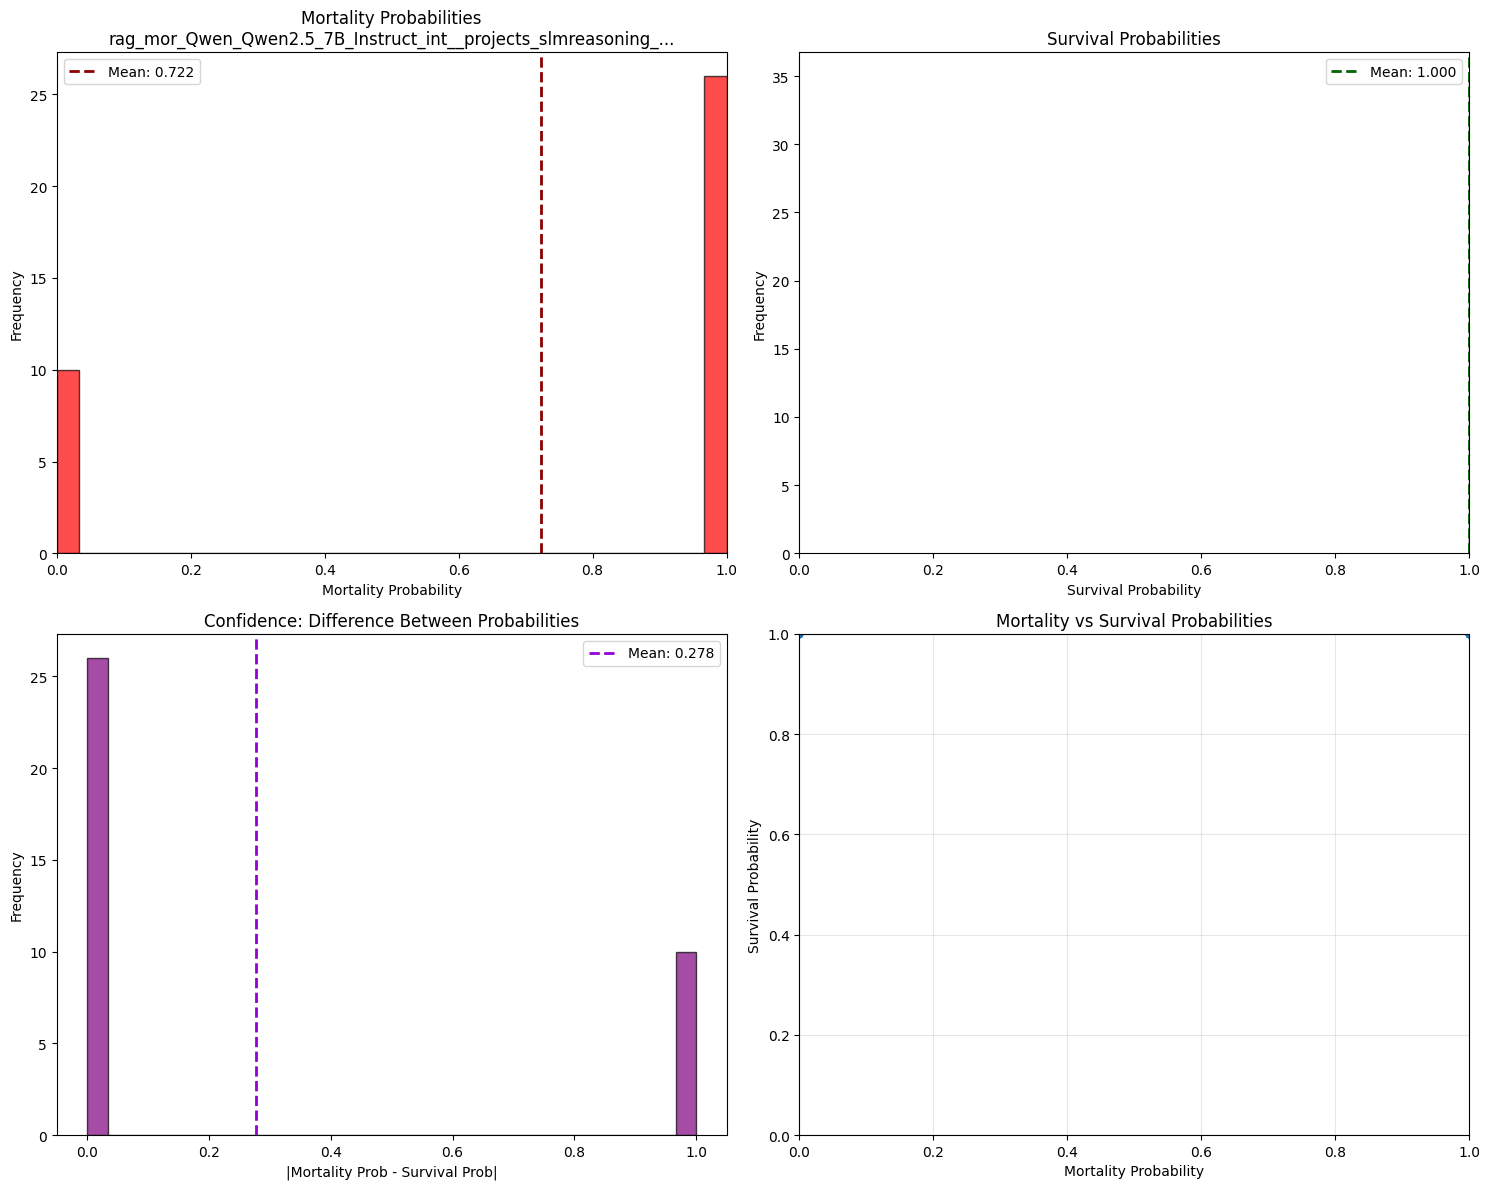


PROBABILITY STATISTICS
Mortality Probability - Mean: 0.7222, Std: 0.4543
Survival Probability - Mean: 1.0000, Std: 0.0000
Confidence (|diff|) - Mean: 0.2778, Std: 0.4543
High confidence (|diff| > 0.5): 10 (27.78%)
Low confidence (|diff| < 0.2): 26 (72.22%)


In [17]:
# For all 996 patient ids, screen the debate_logs folder under each folder in base_path_rag
# extract the final integrator two probabilities in "EXTRACTED MORTALITY PROBABILITY:" and "EXTRACTED SURVIVAL PROBABILITY:"
# plot the distribution of the two probabilities for each model separately

import re

def extract_probabilities_from_log(log_path):
    """Extract mortality and survival probabilities from a debate log file."""
    try:
        with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()
        
        # Look for extracted probabilities
        mortality_pattern = r'EXTRACTED MORTALITY PROBABILITY[:\s]+([0-9.]+)'
        survival_pattern = r'EXTRACTED SURVIVAL PROBABILITY[:\s]+([0-9.]+)'
        
        mortality_matches = re.findall(mortality_pattern, content)
        survival_matches = re.findall(survival_pattern, content)
        
        # Get the last (final) probabilities
        mortality_prob = float(mortality_matches[-1]) if mortality_matches else None
        survival_prob = float(survival_matches[-1]) if survival_matches else None
        
        return mortality_prob, survival_prob
    except Exception as e:
        return None, None

# Collect probabilities per model
model_probabilities = {}
model_invalid_probabilities = {}

for model_dir in os.listdir(base_path_rag):
    model_path = os.path.join(base_path_rag, model_dir)
    debate_logs_path = os.path.join(model_path, 'debate_logs')
    
    if not os.path.isdir(debate_logs_path):
        continue
    
    print(f"Processing {model_dir}...")
    
    model_probs = []
    model_invalid = []
    
    log_files = [f for f in os.listdir(debate_logs_path) if f.startswith('debate_responses_') and f.endswith('.log')]
    
    for log_file in log_files:
        log_path = os.path.join(debate_logs_path, log_file)
        patient_id = log_file.replace('debate_responses_', '').replace('.log', '')
        
        mortality_prob, survival_prob = extract_probabilities_from_log(log_path)
        
        if mortality_prob is not None and survival_prob is not None:
            # Check for invalid probabilities (> 1)
            is_valid = True
            if mortality_prob > 1 or survival_prob > 1:
                is_valid = False
                model_invalid.append({
                    'patient_id': patient_id,
                    'mortality_prob': mortality_prob,
                    'survival_prob': survival_prob
                })
            
            # Only include valid probabilities in analysis
            if is_valid:
                model_probs.append({
                    'patient_id': patient_id,
                    'mortality_prob': mortality_prob,
                    'survival_prob': survival_prob,
                    'diff': abs(mortality_prob - survival_prob)
                })
    
    if len(model_probs) > 0:
        model_probabilities[model_dir] = pd.DataFrame(model_probs)
        if len(model_invalid) > 0:
            model_invalid_probabilities[model_dir] = model_invalid

# Print invalid probabilities summary
if len(model_invalid_probabilities) > 0:
    print("\n" + "=" * 80)
    print("INVALID PROBABILITIES DETECTED (> 1.0)")
    print("=" * 80)
    for model_name, invalid_list in model_invalid_probabilities.items():
        print(f"\n{model_name}: {len(invalid_list)} invalid cases")
        for inv in invalid_list[:5]:  # Show first 5 per model
            print(f"  Patient {inv['patient_id']}: Mort={inv['mortality_prob']:.4f}, Surv={inv['survival_prob']:.4f}")
        if len(invalid_list) > 5:
            print(f"  ... and {len(invalid_list) - 5} more")
    print("=" * 80 + "\n")

# Plot each model separately
num_models = len(model_probabilities)
print(f"\nTotal models with valid probability data: {num_models}\n")

for model_name, prob_df in model_probabilities.items():
    print(f"\n{'=' * 80}")
    print(f"MODEL: {model_name}")
    print('=' * 80)
    print(f"Valid probability pairs: {len(prob_df)}")
    
    # Create plots for this model
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Distribution of mortality probabilities
    axes[0, 0].hist(prob_df['mortality_prob'], bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[0, 0].set_xlabel('Mortality Probability')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'Mortality Probabilities\n{model_name[:60]}...' if len(model_name) > 60 else f'Mortality Probabilities\n{model_name}')
    axes[0, 0].axvline(prob_df['mortality_prob'].mean(), color='darkred', linestyle='--', linewidth=2, 
                       label=f'Mean: {prob_df["mortality_prob"].mean():.3f}')
    axes[0, 0].legend()
    axes[0, 0].set_xlim(0, 1)
    
    # Plot 2: Distribution of survival probabilities
    axes[0, 1].hist(prob_df['survival_prob'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_xlabel('Survival Probability')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Survival Probabilities')
    axes[0, 1].axvline(prob_df['survival_prob'].mean(), color='darkgreen', linestyle='--', linewidth=2, 
                       label=f'Mean: {prob_df["survival_prob"].mean():.3f}')
    axes[0, 1].legend()
    axes[0, 1].set_xlim(0, 1)
    
    # Plot 3: Difference between probabilities (model confidence)
    axes[1, 0].hist(prob_df['diff'], bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].set_xlabel('|Mortality Prob - Survival Prob|')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Confidence: Difference Between Probabilities')
    axes[1, 0].axvline(prob_df['diff'].mean(), color='darkviolet', linestyle='--', linewidth=2, 
                       label=f'Mean: {prob_df["diff"].mean():.3f}')
    axes[1, 0].legend()
    
    # Plot 4: Scatter plot showing relationship
    axes[1, 1].scatter(prob_df['mortality_prob'], prob_df['survival_prob'], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('Mortality Probability')
    axes[1, 1].set_ylabel('Survival Probability')
    axes[1, 1].set_title('Mortality vs Survival Probabilities')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nPROBABILITY STATISTICS")
    print(f"Mortality Probability - Mean: {prob_df['mortality_prob'].mean():.4f}, Std: {prob_df['mortality_prob'].std():.4f}")
    print(f"Survival Probability - Mean: {prob_df['survival_prob'].mean():.4f}, Std: {prob_df['survival_prob'].std():.4f}")
    print(f"Confidence (|diff|) - Mean: {prob_df['diff'].mean():.4f}, Std: {prob_df['diff'].std():.4f}")
    print(f"High confidence (|diff| > 0.5): {len(prob_df[prob_df['diff'] > 0.5])} ({len(prob_df[prob_df['diff'] > 0.5])/len(prob_df)*100:.2f}%)")
    print(f"Low confidence (|diff| < 0.2): {len(prob_df[prob_df['diff'] < 0.2])} ({len(prob_df[prob_df['diff'] < 0.2])/len(prob_df)*100:.2f}%)")

# Store for next cell
prob_df_by_model = model_probabilities


Total mortality cases (label=1): 54

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_format_enforcer_7b_step57_MedCPT_8_8
Probability data for 52 predictions on mortality cases


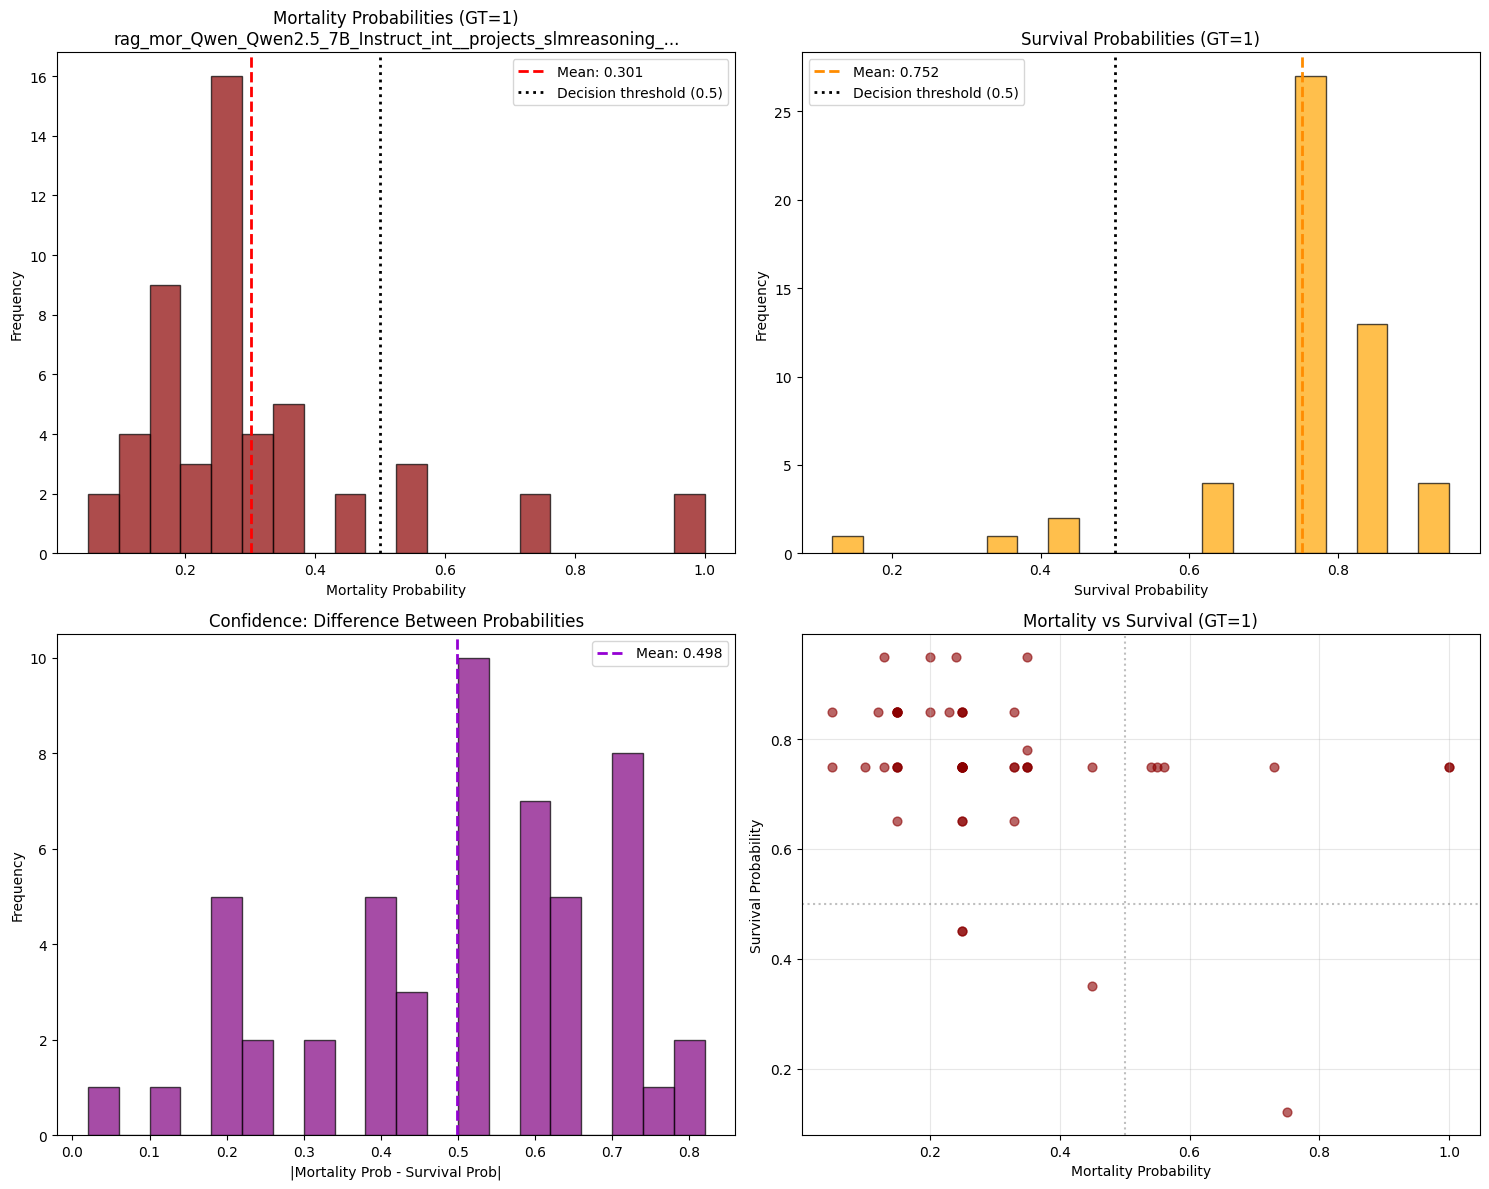


PROBABILITY STATISTICS FOR MORTALITY CASES (GT=1)
Mortality Probability - Mean: 0.3010, Std: 0.2048
Survival Probability - Mean: 0.7519, Std: 0.1447
Confidence (|diff|) - Mean: 0.4983, Std: 0.1909

Correctly identified (mortality_prob > 0.5): 7 / 52 (13.46%)
High confidence (|diff| > 0.5): 24 (46.15%)
Low confidence (|diff| < 0.2): 4 (7.69%)

MODEL: fallback_rag_mor_Qwen_Qwen2.5_7B_Instruct_8_8
Probability data for 41 predictions on mortality cases


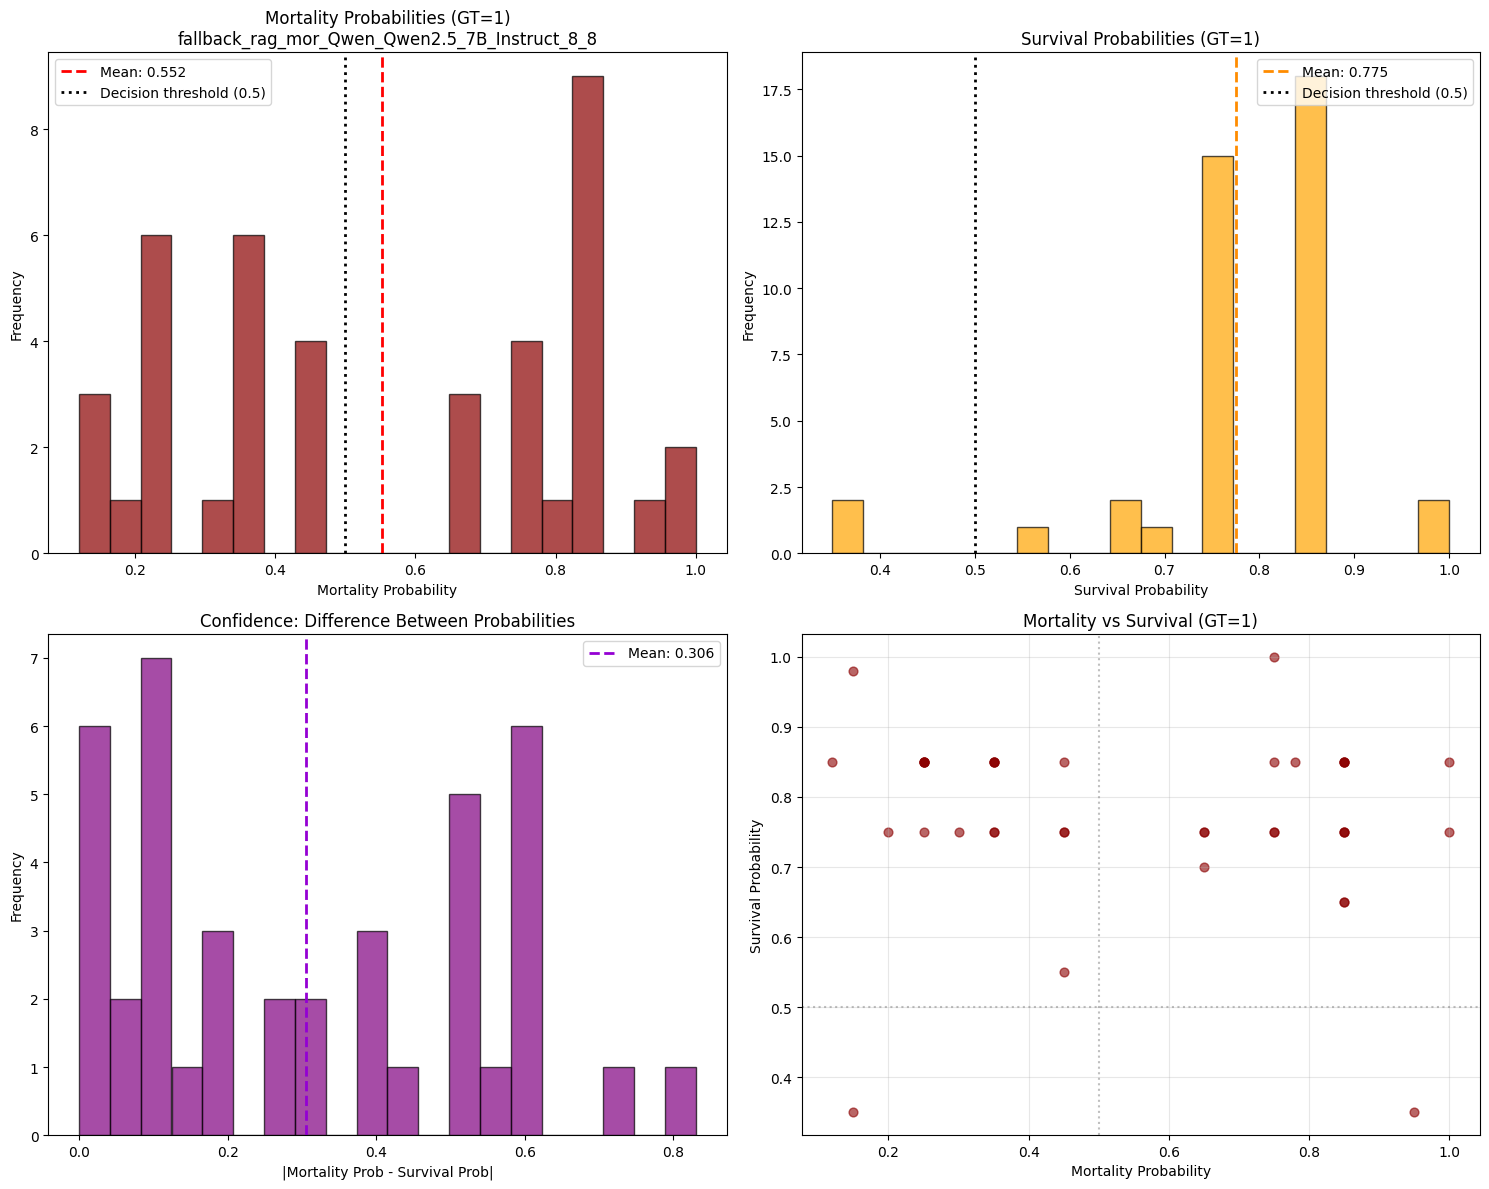


PROBABILITY STATISTICS FOR MORTALITY CASES (GT=1)
Mortality Probability - Mean: 0.5524, Std: 0.2796
Survival Probability - Mean: 0.7751, Std: 0.1277
Confidence (|diff|) - Mean: 0.3056, Std: 0.2404

Correctly identified (mortality_prob > 0.5): 20 / 41 (48.78%)
High confidence (|diff| > 0.5): 9 (21.95%)
Low confidence (|diff| < 0.2): 19 (46.34%)

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8
Probability data for 53 predictions on mortality cases


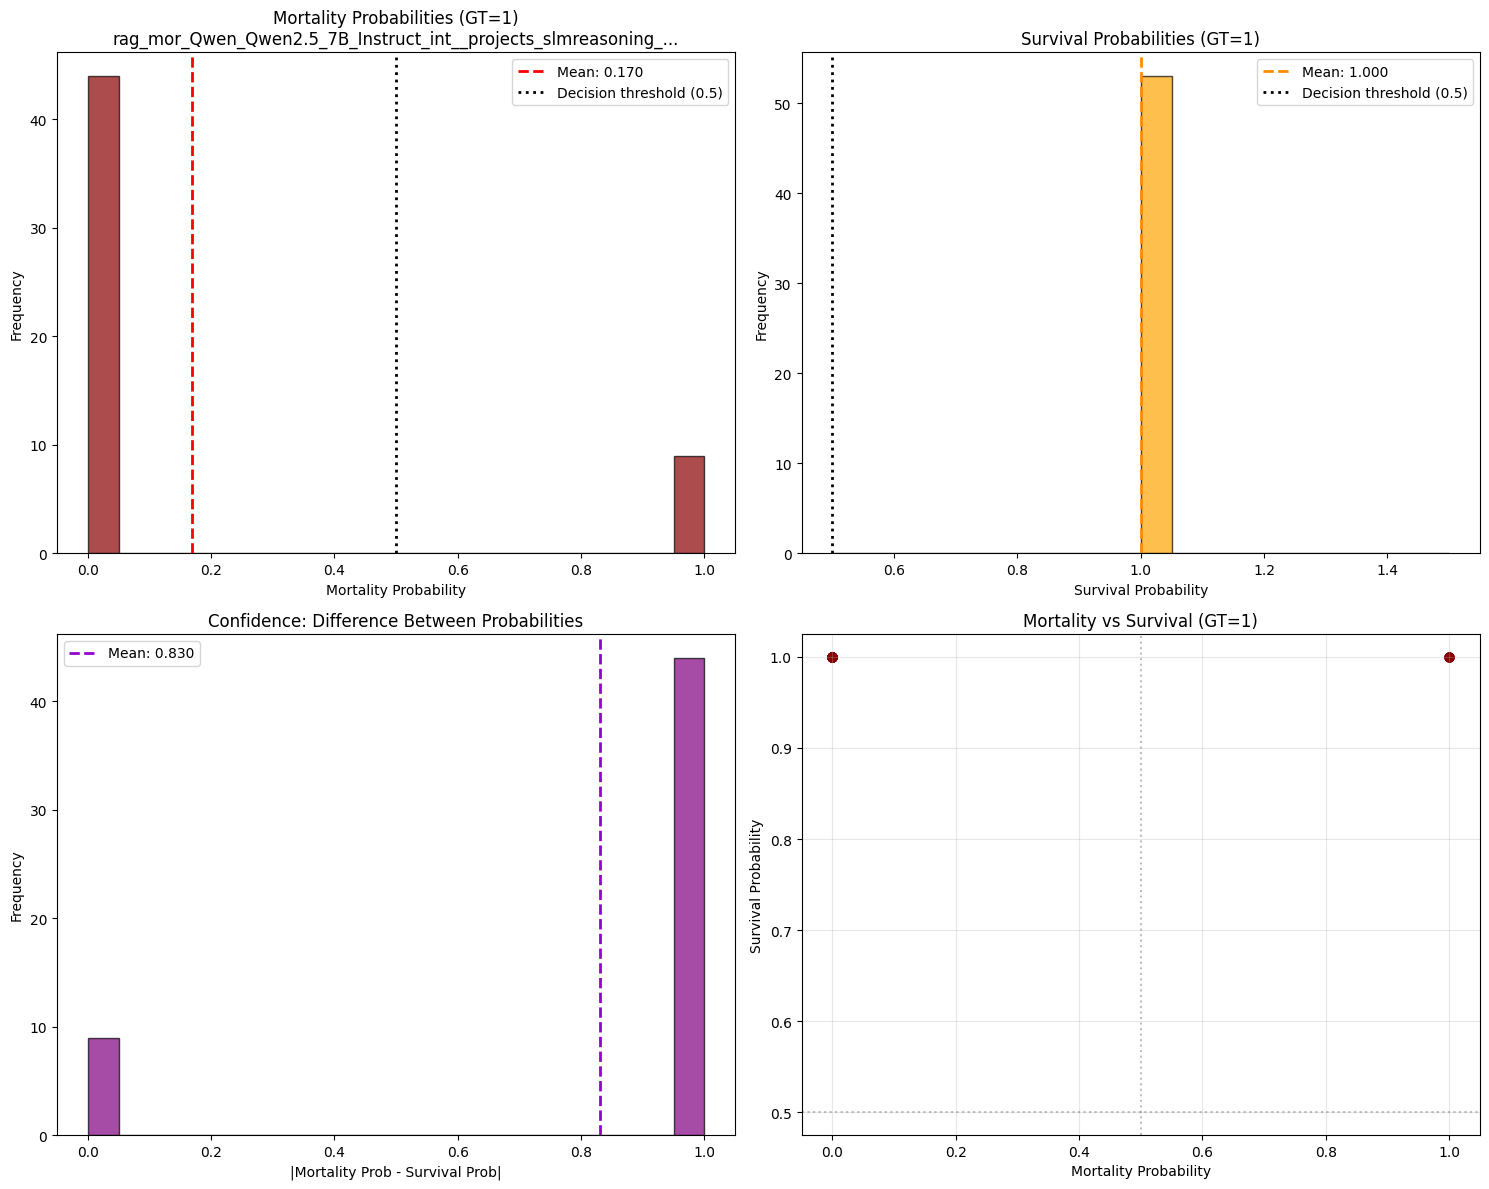


PROBABILITY STATISTICS FOR MORTALITY CASES (GT=1)
Mortality Probability - Mean: 0.1698, Std: 0.3791
Survival Probability - Mean: 1.0000, Std: 0.0000
Confidence (|diff|) - Mean: 0.8302, Std: 0.3791

Correctly identified (mortality_prob > 0.5): 9 / 53 (16.98%)
High confidence (|diff| > 0.5): 44 (83.02%)
Low confidence (|diff| < 0.2): 9 (16.98%)

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_both_format_enforcer_7b_step57_MedCPT_8_8
Probability data for 54 predictions on mortality cases


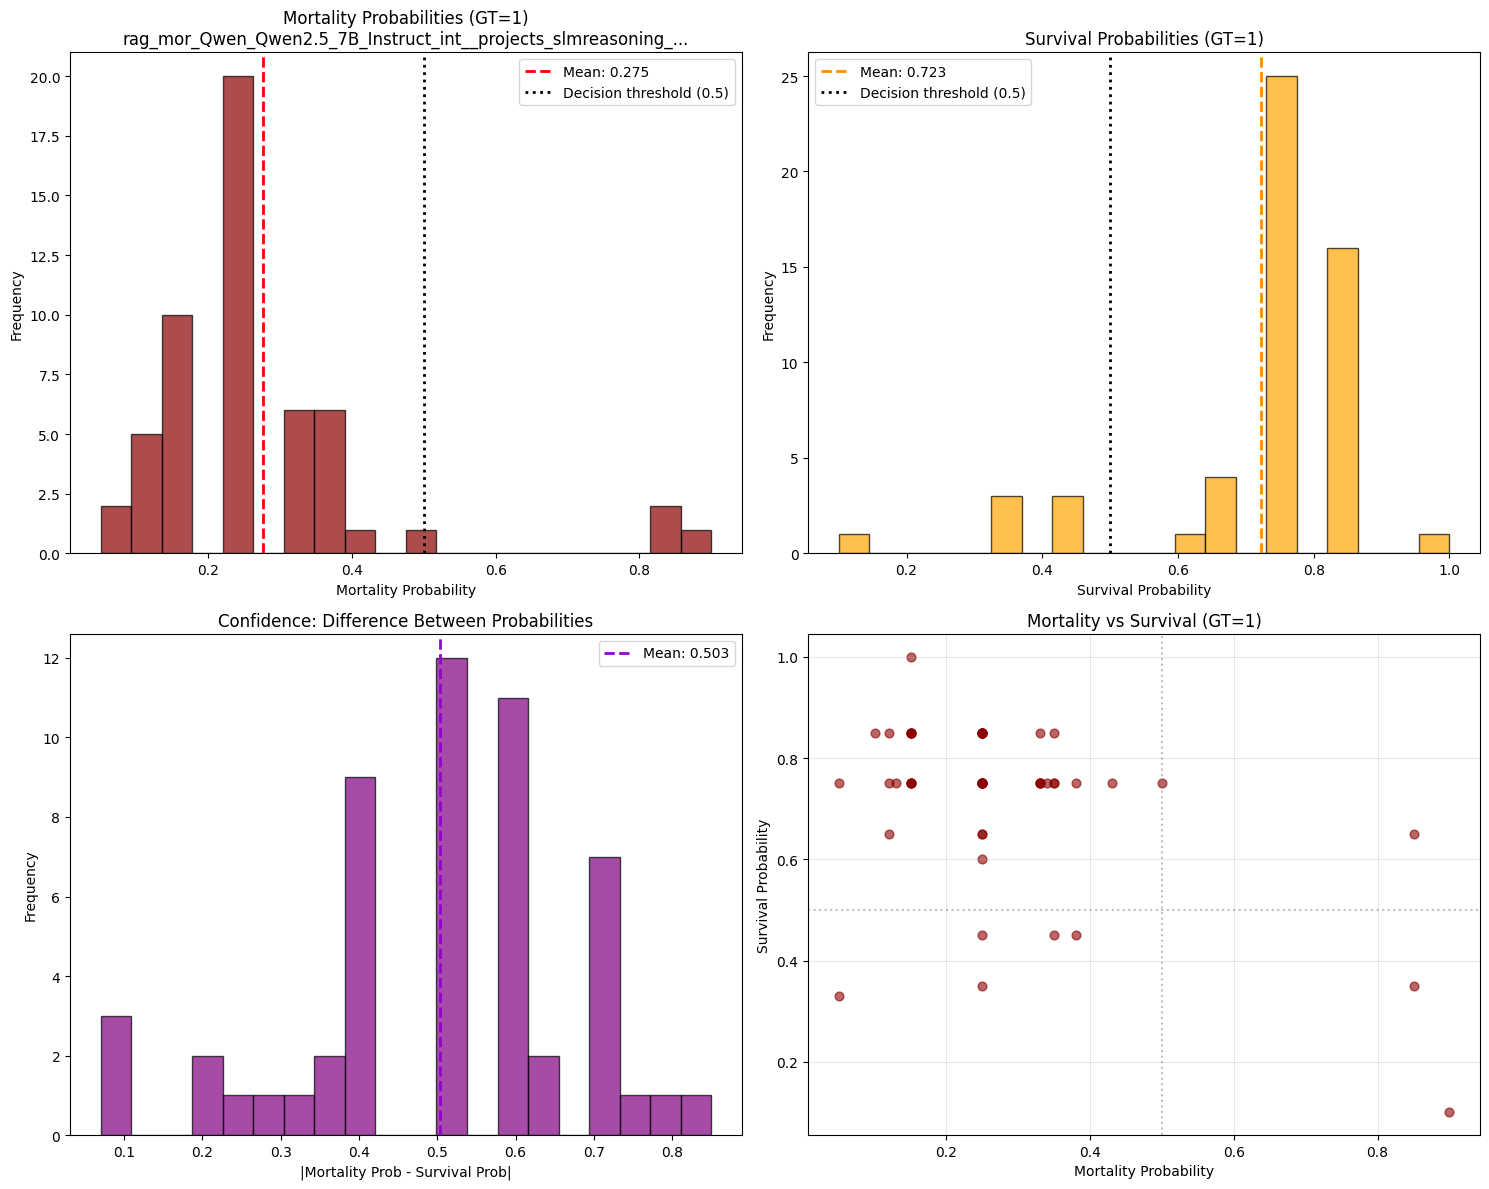


PROBABILITY STATISTICS FOR MORTALITY CASES (GT=1)
Mortality Probability - Mean: 0.2754, Std: 0.1729
Survival Probability - Mean: 0.7228, Std: 0.1645
Confidence (|diff|) - Mean: 0.5030, Std: 0.1765

Correctly identified (mortality_prob > 0.5): 3 / 54 (5.56%)
High confidence (|diff| > 0.5): 25 (46.30%)
Low confidence (|diff| < 0.2): 4 (7.41%)

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_unlabel_7b_step150_MedCPT_8_8
Probability data for 2 predictions on mortality cases


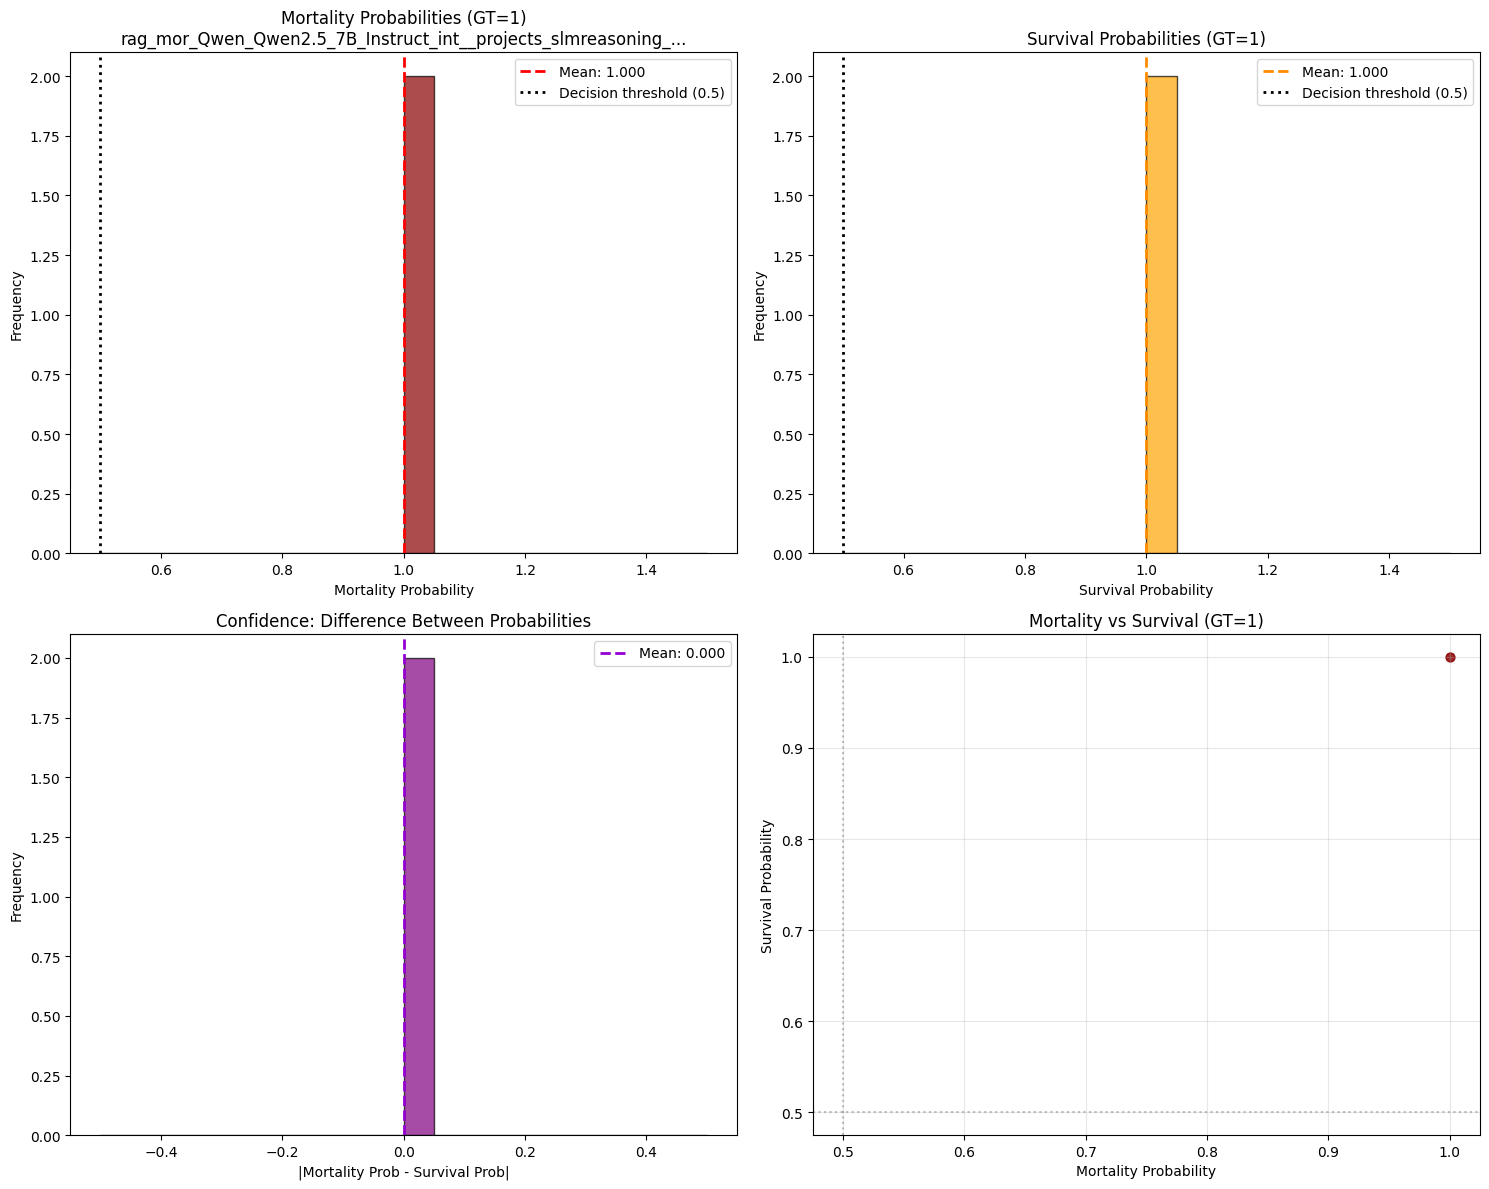


PROBABILITY STATISTICS FOR MORTALITY CASES (GT=1)
Mortality Probability - Mean: 1.0000, Std: 0.0000
Survival Probability - Mean: 1.0000, Std: 0.0000
Confidence (|diff|) - Mean: 0.0000, Std: 0.0000

Correctly identified (mortality_prob > 0.5): 2 / 2 (100.00%)
High confidence (|diff| > 0.5): 0 (0.00%)
Low confidence (|diff| < 0.2): 2 (100.00%)


In [18]:
# from dataset filtering out the patients' id whose ground truth label is 1
# perform the same probability distribution plot as above only for those patients
# Plot separately for each model

# Filter for mortality cases (label = 1)
mortality_patient_ids = [f"{p['patient_id']}_{p['visit_id']}" for p in patient_data if p['label'] == 1]
print(f"Total mortality cases (label=1): {len(mortality_patient_ids)}")

# Analyze each model separately
for model_name, prob_df in prob_df_by_model.items():
    # Filter probabilities for mortality cases
    mortality_cases_df = prob_df[prob_df['patient_id'].isin(mortality_patient_ids)]
    
    if len(mortality_cases_df) == 0:
        print(f"\nNo probability data for mortality cases in {model_name}")
        continue
    
    print(f"\n{'=' * 80}")
    print(f"MODEL: {model_name}")
    print('=' * 80)
    print(f"Probability data for {len(mortality_cases_df)} predictions on mortality cases")
    
    # Plot distributions for mortality cases only
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Distribution of mortality probabilities for actual mortality cases
    axes[0, 0].hist(mortality_cases_df['mortality_prob'], bins=20, alpha=0.7, color='darkred', edgecolor='black')
    axes[0, 0].set_xlabel('Mortality Probability')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'Mortality Probabilities (GT=1)\n{model_name[:60]}...' if len(model_name) > 60 else f'Mortality Probabilities (GT=1)\n{model_name}')
    axes[0, 0].axvline(mortality_cases_df['mortality_prob'].mean(), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {mortality_cases_df["mortality_prob"].mean():.3f}')
    axes[0, 0].axvline(0.5, color='black', linestyle=':', linewidth=2, label='Decision threshold (0.5)')
    axes[0, 0].legend()
    
    # Plot 2: Distribution of survival probabilities for actual mortality cases
    axes[0, 1].hist(mortality_cases_df['survival_prob'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 1].set_xlabel('Survival Probability')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Survival Probabilities (GT=1)')
    axes[0, 1].axvline(mortality_cases_df['survival_prob'].mean(), color='darkorange', linestyle='--', linewidth=2, 
                       label=f'Mean: {mortality_cases_df["survival_prob"].mean():.3f}')
    axes[0, 1].axvline(0.5, color='black', linestyle=':', linewidth=2, label='Decision threshold (0.5)')
    axes[0, 1].legend()
    
    # Plot 3: Confidence for mortality cases
    axes[1, 0].hist(mortality_cases_df['diff'], bins=20, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].set_xlabel('|Mortality Prob - Survival Prob|')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Confidence: Difference Between Probabilities')
    axes[1, 0].axvline(mortality_cases_df['diff'].mean(), color='darkviolet', linestyle='--', linewidth=2, 
                       label=f'Mean: {mortality_cases_df["diff"].mean():.3f}')
    axes[1, 0].legend()
    
    # Plot 4: Scatter plot for mortality cases
    axes[1, 1].scatter(mortality_cases_df['mortality_prob'], mortality_cases_df['survival_prob'], 
                      alpha=0.6, s=40, color='darkred')
    axes[1, 1].axhline(0.5, color='gray', linestyle=':', alpha=0.5)
    axes[1, 1].axvline(0.5, color='gray', linestyle=':', alpha=0.5)
    axes[1, 1].set_xlabel('Mortality Probability')
    axes[1, 1].set_ylabel('Survival Probability')
    axes[1, 1].set_title('Mortality vs Survival (GT=1)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nPROBABILITY STATISTICS FOR MORTALITY CASES (GT=1)")
    print(f"Mortality Probability - Mean: {mortality_cases_df['mortality_prob'].mean():.4f}, Std: {mortality_cases_df['mortality_prob'].std():.4f}")
    print(f"Survival Probability - Mean: {mortality_cases_df['survival_prob'].mean():.4f}, Std: {mortality_cases_df['survival_prob'].std():.4f}")
    print(f"Confidence (|diff|) - Mean: {mortality_cases_df['diff'].mean():.4f}, Std: {mortality_cases_df['diff'].std():.4f}")
    
    # How many were correctly identified (mortality_prob > 0.5)?
    correct_mort = len(mortality_cases_df[mortality_cases_df['mortality_prob'] > 0.5])
    print(f"\nCorrectly identified (mortality_prob > 0.5): {correct_mort} / {len(mortality_cases_df)} ({correct_mort/len(mortality_cases_df)*100:.2f}%)")
    
    # Confidence analysis
    print(f"High confidence (|diff| > 0.5): {len(mortality_cases_df[mortality_cases_df['diff'] > 0.5])} ({len(mortality_cases_df[mortality_cases_df['diff'] > 0.5])/len(mortality_cases_df)*100:.2f}%)")
    print(f"Low confidence (|diff| < 0.2): {len(mortality_cases_df[mortality_cases_df['diff'] < 0.2])} ({len(mortality_cases_df[mortality_cases_df['diff'] < 0.2])/len(mortality_cases_df)*100:.2f}%)")


Processing fallback_rag_mor_Qwen_Qwen2.5_7B_Instruct_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_both_format_enforcer_7b_step57_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_both_format_enforcer_7b_step57_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_format_enforcer_7b_step57_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_format_enforcer_7b_step57_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8...
Processing rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KAR

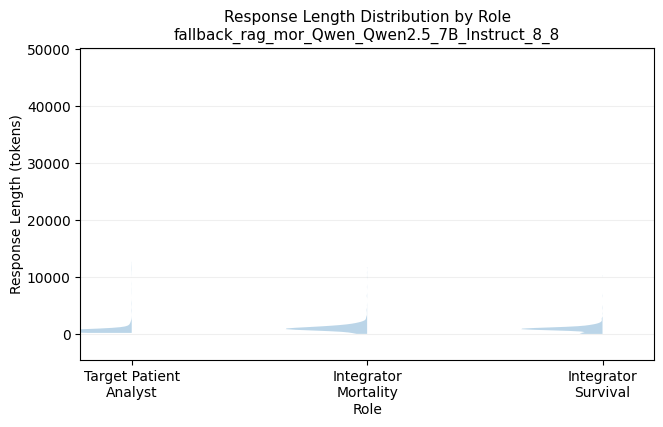


RESPONSE LENGTH STATISTICS BY ROLE

Target Patient Analyst:
  Count: 996
  Mean: 753.85 tokens
  Median: 585.25 tokens
  Std: 1032.10 tokens
  Min: 244, Max: 12694

Integrator Mortality:
  Count: 996
  Mean: 1116.00 tokens
  Median: 997.38 tokens
  Std: 819.83 tokens
  Min: 74, Max: 11787

Integrator Survival:
  Count: 996
  Mean: 940.02 tokens
  Median: 929.38 tokens
  Std: 586.75 tokens
  Min: 67, Max: 10322

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_both_format_enforcer_7b_step57_MedCPT_8_8


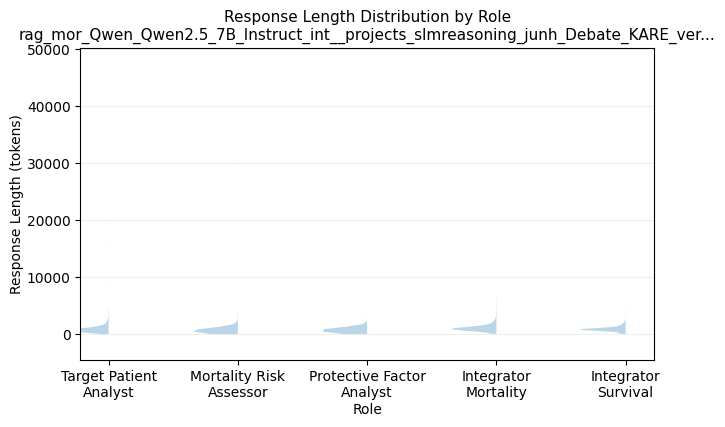


RESPONSE LENGTH STATISTICS BY ROLE

Target Patient Analyst:
  Count: 996
  Mean: 926.23 tokens
  Median: 664.50 tokens
  Std: 1195.13 tokens
  Min: 20, Max: 19491

Mortality Risk Assessor:
  Count: 996
  Mean: 729.30 tokens
  Median: 568.00 tokens
  Std: 2060.85 tokens
  Min: 32, Max: 41696

Protective Factor Analyst:
  Count: 996
  Mean: 755.68 tokens
  Median: 654.38 tokens
  Std: 1922.23 tokens
  Min: 30, Max: 43482

Integrator Mortality:
  Count: 996
  Mean: 1120.29 tokens
  Median: 966.25 tokens
  Std: 941.59 tokens
  Min: 76, Max: 19116

Integrator Survival:
  Count: 996
  Mean: 928.76 tokens
  Median: 867.50 tokens
  Std: 542.13 tokens
  Min: 74, Max: 7985

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_format_enforcer_7b_step57_MedCPT_8_8


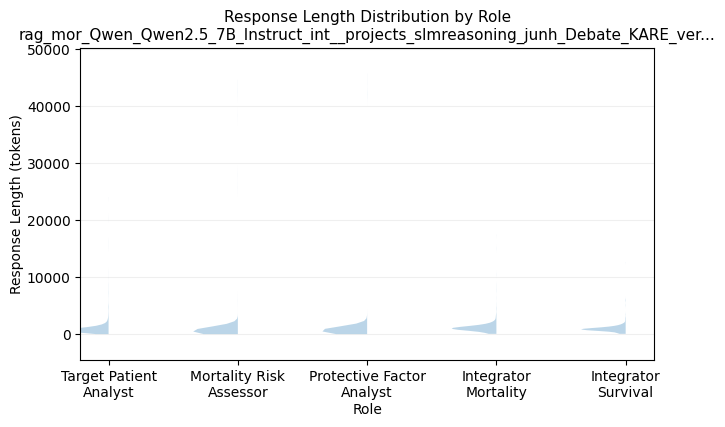


RESPONSE LENGTH STATISTICS BY ROLE

Target Patient Analyst:
  Count: 996
  Mean: 975.35 tokens
  Median: 653.38 tokens
  Std: 1453.01 tokens
  Min: 30, Max: 24008

Mortality Risk Assessor:
  Count: 996
  Mean: 812.68 tokens
  Median: 566.38 tokens
  Std: 2880.42 tokens
  Min: 30, Max: 44591

Protective Factor Analyst:
  Count: 996
  Mean: 838.72 tokens
  Median: 647.88 tokens
  Std: 2718.86 tokens
  Min: 30, Max: 45665

Integrator Mortality:
  Count: 996
  Mean: 1149.25 tokens
  Median: 1034.25 tokens
  Std: 1015.88 tokens
  Min: 74, Max: 17478

Integrator Survival:
  Count: 996
  Mean: 962.92 tokens
  Median: 890.38 tokens
  Std: 668.54 tokens
  Min: 76, Max: 12660

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8


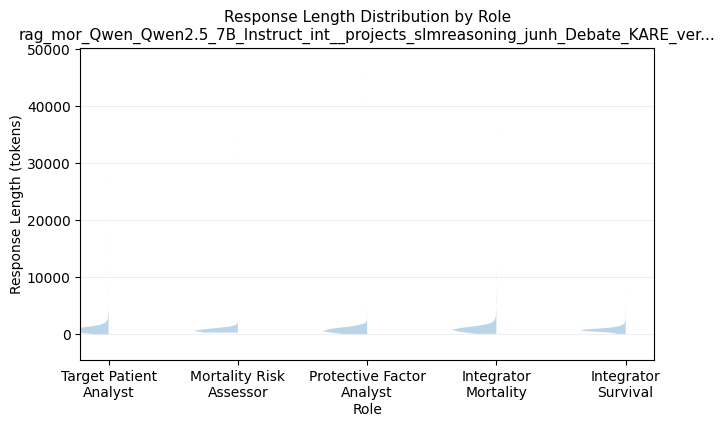


RESPONSE LENGTH STATISTICS BY ROLE

Target Patient Analyst:
  Count: 968
  Mean: 958.92 tokens
  Median: 651.50 tokens
  Std: 1541.34 tokens
  Min: 8, Max: 27281

Mortality Risk Assessor:
  Count: 968
  Mean: 668.49 tokens
  Median: 572.50 tokens
  Std: 1467.78 tokens
  Min: 291, Max: 34630

Protective Factor Analyst:
  Count: 968
  Mean: 717.75 tokens
  Median: 595.75 tokens
  Std: 1940.50 tokens
  Min: 32, Max: 45646

Integrator Mortality:
  Count: 968
  Mean: 950.86 tokens
  Median: 793.12 tokens
  Std: 1460.28 tokens
  Min: 74, Max: 35438

Integrator Survival:
  Count: 968
  Mean: 812.00 tokens
  Median: 736.12 tokens
  Std: 573.38 tokens
  Min: 60, Max: 7778

MODEL: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_unlabel_7b_step150_MedCPT_8_8


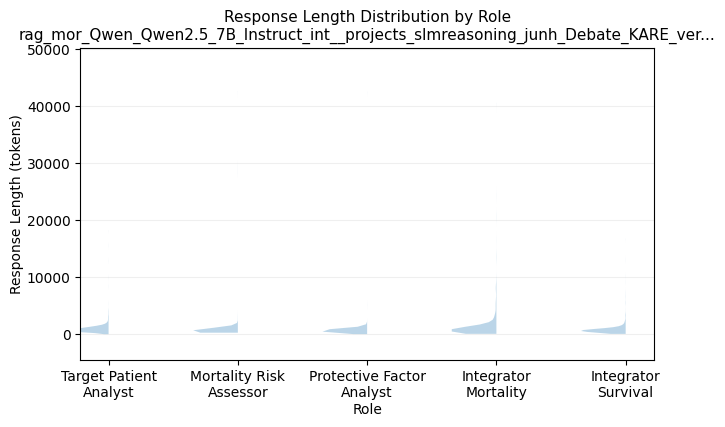


RESPONSE LENGTH STATISTICS BY ROLE

Target Patient Analyst:
  Count: 995
  Mean: 938.00 tokens
  Median: 699.25 tokens
  Std: 1019.59 tokens
  Min: 17, Max: 18216

Mortality Risk Assessor:
  Count: 995
  Mean: 698.20 tokens
  Median: 572.00 tokens
  Std: 1845.82 tokens
  Min: 277, Max: 42607

Protective Factor Analyst:
  Count: 995
  Mean: 683.81 tokens
  Median: 603.75 tokens
  Std: 1347.28 tokens
  Min: 32, Max: 42506

Integrator Mortality:
  Count: 995
  Mean: 1199.83 tokens
  Median: 723.25 tokens
  Std: 2288.75 tokens
  Min: 78, Max: 40538

Integrator Survival:
  Count: 995
  Mean: 802.77 tokens
  Median: 642.75 tokens
  Std: 1009.05 tokens
  Min: 70, Max: 16768


In [30]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# CONFIG
# ----------------------------
# base_path_rag = "/path/to/your/results"  # <-- set this

# ----------------------------
# HELPERS
# ----------------------------
def extract_role_responses(log_path):
    """Extract response lengths (approx tokens) for each role from a debate log file."""
    try:
        with open(log_path, "r", encoding="utf-8", errors="ignore") as f:
            content = f.read()

        roles_data = {}

        patterns = {
            "target_patient_analyst": r"RAW RESPONSE from TARGET_PATIENT_ANALYST.*?Response length: (\d+)",
            "mortality_risk_assessor": r"BATCH RESPONSE from MORTALITY_RISK_ASSESSOR.*?Response length: (\d+)",
            "protective_factor_analyst": r"BATCH RESPONSE from PROTECTIVE_FACTOR_ANALYST.*?Response length: (\d+)",
            "integrator_mortality": r"MORTALITY RAW LLM RESPONSE:.*?(?=SURVIVAL RAW LLM RESPONSE:|$)",
            "integrator_survival": r"SURVIVAL RAW LLM RESPONSE:.*?(?=RAW RESPONSE from BALANCED_CLINICAL_INTEGRATOR|$)",
        }

        for role, pattern in patterns.items():
            if "integrator" in role:
                m = re.search(pattern, content, re.DOTALL)
                if m:
                    char_length = len(m.group(0))
                    roles_data[role] = char_length / 4.0
            else:
                m = re.search(pattern, content, re.DOTALL)
                if m:
                    char_length = int(m.group(1))
                    roles_data[role] = char_length / 4.0

        return roles_data
    except Exception:
        return {}


def make_half_violin(body, x_center, side="left"):
    """Clip a single matplotlib violin body to half (left or right) by editing vertices."""
    paths = body.get_paths()
    if not paths:
        return
    path = paths[0]
    verts = path.vertices
    if verts.size == 0:
        return

    if side == "left":
        verts[:, 0] = np.minimum(verts[:, 0], x_center)
    elif side == "right":
        verts[:, 0] = np.maximum(verts[:, 0], x_center)
    else:
        raise ValueError("side must be 'left' or 'right'")

    path.vertices = verts


# ----------------------------
# MAIN
# ----------------------------
model_role_lengths = {}

for model_dir in sorted(os.listdir(base_path_rag)):
    model_path = os.path.join(base_path_rag, model_dir)
    debate_logs_path = os.path.join(model_path, "debate_logs")
    if not os.path.isdir(debate_logs_path):
        continue

    print(f"Processing {model_dir}...")

    role_lengths = {
        "target_patient_analyst": [],
        "mortality_risk_assessor": [],
        "protective_factor_analyst": [],
        "integrator_mortality": [],
        "integrator_survival": [],
    }

    log_files = [
        f for f in os.listdir(debate_logs_path)
        if f.startswith("debate_responses_") and f.endswith(".log")
    ]

    for log_file in log_files:
        log_path = os.path.join(debate_logs_path, log_file)
        lengths = extract_role_responses(log_path)
        for role, length in lengths.items():
            role_lengths[role].append(length)

    if any(len(v) > 0 for v in role_lengths.values()):
        model_role_lengths[model_dir] = role_lengths

role_names_display = {
    "target_patient_analyst": "Target Patient\nAnalyst",
    "mortality_risk_assessor": "Mortality Risk\nAssessor",
    "protective_factor_analyst": "Protective Factor\nAnalyst",
    "integrator_mortality": "Integrator\nMortality",
    "integrator_survival": "Integrator\nSurvival",
}

roles_order = [
    "target_patient_analyst",
    "mortality_risk_assessor",
    "protective_factor_analyst",
    "integrator_mortality",
    "integrator_survival",
]

# Consistent y-axis across models
all_lengths = []
for _, rl in model_role_lengths.items():
    for _, lengths in rl.items():
        all_lengths.extend(lengths)

global_min = min(all_lengths) if all_lengths else 0
global_max = max(all_lengths) if all_lengths else 1000
y_margin = (global_max - global_min) * 0.1 if global_max > global_min else 50
ylim = (global_min - y_margin, global_max + y_margin)

# ---- spacing controls (THIS is what makes x-axis tight) ----
STEP = 0.55           # smaller -> categories closer together (try 0.45 if you want even tighter)
VIOLIN_WIDTH = 0.38   # width in data-x units (should be <= STEP)
BOX_WIDTH = 0.14      # box width in data-x units
X_PAD = 0.12          # xlim padding

for model_name, role_lengths in model_role_lengths.items():
    print(f"\n{'=' * 80}")
    print(f"MODEL: {model_name}")
    print("=" * 80)

    # Build per-role data, keeping the original order but skipping empty roles
    data_list = []
    label_list = []
    for role in roles_order:
        arr = role_lengths.get(role, [])
        if len(arr) > 0:
            data_list.append(arr)
            label_list.append(role_names_display[role])

    if not data_list:
        print("No data available for this model")
        continue

    n = len(data_list)
    positions = np.arange(n) * STEP

    # Compact figure width scales with number of roles
    fig_w = max(6.2, 1.15 * n)   # tighter than your previous wide plots
    fig_h = 4.6
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    vp = ax.violinplot(
        data_list,
        positions=positions,
        widths=VIOLIN_WIDTH,
        showmeans=False,
        showmedians=False,
        showextrema=False,
    )

    # Half violins (left side only)
    for i, body in enumerate(vp["bodies"]):
        make_half_violin(body, x_center=positions[i], side="left")

    # Tight x-axis: use compressed positions + tight x-limits
    ax.set_xlim(positions[0] - X_PAD, positions[-1] + X_PAD)
    ax.margins(x=0.0)

    # Labels
    ax.set_xticks(positions)
    ax.set_xticklabels(label_list)

    # Y axis
    ax.set_ylim(ylim)
    ax.grid(True, alpha=0.20, axis="y")
    ax.set_axisbelow(True)

    title = (
        f"Response Length Distribution by Role\n{model_name[:80]}..."
        if len(model_name) > 80
        else f"Response Length Distribution by Role\n{model_name}"
    )
    ax.set_title(title, fontsize=11, pad=6)
    ax.set_xlabel("Role", fontsize=10, labelpad=2)
    ax.set_ylabel("Response Length (tokens)", fontsize=10, labelpad=2)

    # Aggressive whitespace trimming
    fig.tight_layout(pad=0.15)
    fig.subplots_adjust(left=0.07, right=0.995, bottom=0.20, top=0.88)

    plt.show()

    # Print statistics
    print("\nRESPONSE LENGTH STATISTICS BY ROLE")
    for role in roles_order:
        lengths = role_lengths.get(role, [])
        if lengths:
            display_name = role_names_display[role].replace("\n", " ")
            print(f"\n{display_name}:")
            print(f"  Count: {len(lengths)}")
            print(f"  Mean: {np.mean(lengths):.2f} tokens")
            print(f"  Median: {np.median(lengths):.2f} tokens")
            print(f"  Std: {np.std(lengths):.2f} tokens")
            print(f"  Min: {np.min(lengths):.0f}, Max: {np.max(lengths):.0f}")


Total patients: 996
Always-wrong patients: 1
Patients with retries: 141


/tmp/ipykernel_1871161/51840723.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=labels, patch_artist=True)


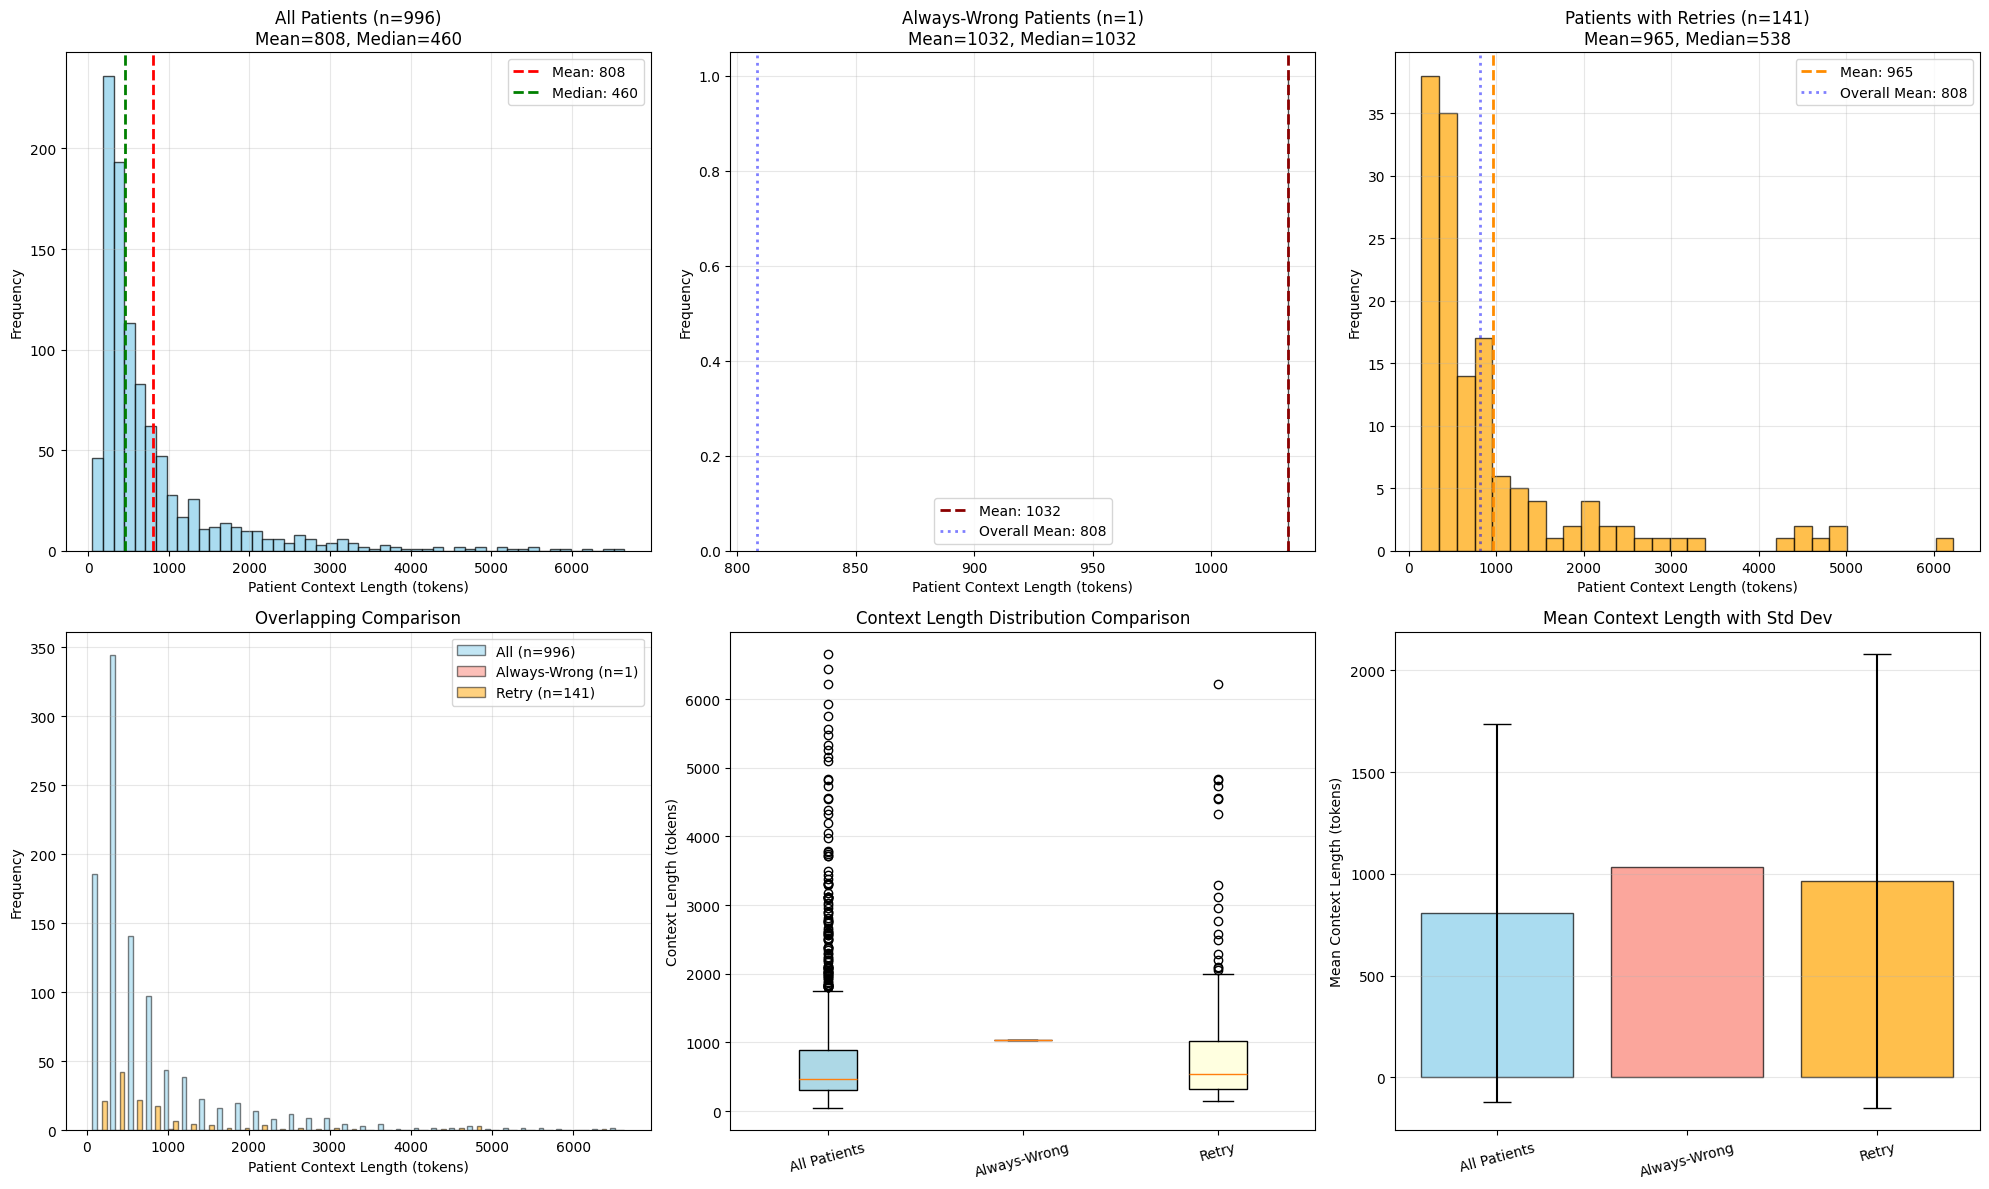


PATIENT CONTEXT LENGTH STATISTICS - GROUP COMPARISON

All Patients (n=996):
  Mean: 808.36 tokens
  Median: 459.75 tokens
  Std: 929.53 tokens
  Min: 48, Max: 6653

Always-Wrong Patients (n=1):
  Mean: 1032.25 tokens
  Median: 1032.25 tokens
  Std: nan tokens
  Min: 1032, Max: 1032
  Difference from overall mean: +223.89 tokens (+27.70%)

Patients with Retries (n=141):
  Mean: 964.93 tokens
  Median: 538.00 tokens
  Std: 1113.51 tokens
  Min: 142, Max: 6223
  Difference from overall mean: +156.57 tokens (+19.37%)

Statistical Test: All vs Always-Wrong
  t-statistic: -0.2407
  p-value: 0.8098
  → No significant difference (p >= 0.05)

Statistical Test: All vs Retry
  t-statistic: -1.8237
  p-value: 0.0685
  → No significant difference (p >= 0.05)

Statistical Test: Always-Wrong vs Retry
  t-statistic: 0.0602
  p-value: 0.9520
  → No significant difference (p >= 0.05)

GROUP OVERLAP ANALYSIS
Patients both always-wrong AND with retries: 1
  Mean context length: 1032.25 tokens


In [20]:
# from the dataset in patient_path, plot the distribution of the patient context lengths
# Compare: All 996 patients vs Always-wrong patients vs Retry patients

# Calculate patient context lengths
patient_context_lengths = []

for patient in patient_data:
    # Concatenate all patient data fields to estimate context length
    context_parts = []
    
    # Add conditions
    if 'conditions' in patient and patient['conditions']:
        for visit_conditions in patient['conditions']:
            context_parts.extend(visit_conditions)
    
    # Add procedures
    if 'procedures' in patient and patient['procedures']:
        for visit_procedures in patient['procedures']:
            context_parts.extend(visit_procedures)
    
    # Add drugs
    if 'drugs' in patient and patient['drugs']:
        for visit_drugs in patient['drugs']:
            context_parts.extend(visit_drugs)
    
    # Calculate total length in tokens (approx 4 chars per token)
    total_context = ' '.join(context_parts)
    context_length = len(total_context) / 4  # Convert to tokens
    
    patient_context_lengths.append({
        'patient_id': f"{patient['patient_id']}_{patient['visit_id']}",
        'context_length': context_length,
        'num_conditions': len(patient['conditions'][0]) if patient.get('conditions') else 0,
        'num_procedures': len(patient['procedures'][0]) if patient.get('procedures') else 0,
        'num_drugs': len(patient['drugs'][0]) if patient.get('drugs') else 0,
        'label': patient['label']
    })

context_df = pd.DataFrame(patient_context_lengths)

# Get always-wrong patients from first analysis
always_wrong_ids = always_wrong if 'always_wrong' in locals() else []

# Get retry patients from second analysis
retry_patient_ids = list(all_retry_patients.keys()) if 'all_retry_patients' in locals() else []

print(f"Total patients: {len(context_df)}")
print(f"Always-wrong patients: {len(always_wrong_ids)}")
print(f"Patients with retries: {len(retry_patient_ids)}")

# Filter data for each group
all_lengths = context_df['context_length']
always_wrong_lengths = context_df[context_df['patient_id'].isin(always_wrong_ids)]['context_length']
retry_lengths = context_df[context_df['patient_id'].isin(retry_patient_ids)]['context_length']

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Overall distribution
axes[0, 0].hist(all_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Patient Context Length (tokens)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'All Patients (n={len(all_lengths)})\nMean={all_lengths.mean():.0f}, Median={all_lengths.median():.0f}')
axes[0, 0].axvline(all_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_lengths.mean():.0f}')
axes[0, 0].axvline(all_lengths.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {all_lengths.median():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Always-wrong distribution
if len(always_wrong_lengths) > 0:
    axes[0, 1].hist(always_wrong_lengths, bins=30, alpha=0.7, color='salmon', edgecolor='black')
    axes[0, 1].set_xlabel('Patient Context Length (tokens)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'Always-Wrong Patients (n={len(always_wrong_lengths)})\nMean={always_wrong_lengths.mean():.0f}, Median={always_wrong_lengths.median():.0f}')
    axes[0, 1].axvline(always_wrong_lengths.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {always_wrong_lengths.mean():.0f}')
    axes[0, 1].axvline(all_lengths.mean(), color='blue', linestyle=':', linewidth=2, alpha=0.5, label=f'Overall Mean: {all_lengths.mean():.0f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No always-wrong patients', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Always-Wrong Patients')

# Plot 3: Retry distribution
if len(retry_lengths) > 0:
    axes[0, 2].hist(retry_lengths, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 2].set_xlabel('Patient Context Length (tokens)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title(f'Patients with Retries (n={len(retry_lengths)})\nMean={retry_lengths.mean():.0f}, Median={retry_lengths.median():.0f}')
    axes[0, 2].axvline(retry_lengths.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Mean: {retry_lengths.mean():.0f}')
    axes[0, 2].axvline(all_lengths.mean(), color='blue', linestyle=':', linewidth=2, alpha=0.5, label=f'Overall Mean: {all_lengths.mean():.0f}')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'No retry patients', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('Patients with Retries')

# Plot 4: Overlapping histograms for comparison
axes[1, 0].hist([all_lengths, always_wrong_lengths, retry_lengths], bins=30, alpha=0.5, 
                color=['skyblue', 'salmon', 'orange'], 
                label=[f'All (n={len(all_lengths)})', 
                       f'Always-Wrong (n={len(always_wrong_lengths)})', 
                       f'Retry (n={len(retry_lengths)})'], 
                edgecolor='black')
axes[1, 0].set_xlabel('Patient Context Length (tokens)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Overlapping Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Box plot comparison
box_data = [all_lengths, always_wrong_lengths, retry_lengths] if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0 else []
labels = ['All Patients', 'Always-Wrong', 'Retry']

if len(box_data) > 0:
    bp = axes[1, 1].boxplot(box_data, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    if len(bp['boxes']) > 1:
        bp['boxes'][1].set_facecolor('lightcoral')
    if len(bp['boxes']) > 2:
        bp['boxes'][2].set_facecolor('lightyellow')
    axes[1, 1].set_ylabel('Context Length (tokens)')
    axes[1, 1].set_title('Context Length Distribution Comparison')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].tick_params(axis='x', rotation=15)
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=axes[1, 1].transAxes)

# Plot 6: Statistical summary bars
if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0:
    means = [all_lengths.mean(), always_wrong_lengths.mean(), retry_lengths.mean()]
    stds = [all_lengths.std(), always_wrong_lengths.std(), retry_lengths.std()]
    
    x_pos = np.arange(len(labels))
    axes[1, 2].bar(x_pos, means, yerr=stds, alpha=0.7, color=['skyblue', 'salmon', 'orange'], 
                   edgecolor='black', capsize=10)
    axes[1, 2].set_ylabel('Mean Context Length (tokens)')
    axes[1, 2].set_title('Mean Context Length with Std Dev')
    axes[1, 2].set_xticks(x_pos)
    axes[1, 2].set_xticklabels(labels, rotation=15)
    axes[1, 2].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 2].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=axes[1, 2].transAxes)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "=" * 80)
print("PATIENT CONTEXT LENGTH STATISTICS - GROUP COMPARISON")
print("=" * 80)

print(f"\nAll Patients (n={len(all_lengths)}):")
print(f"  Mean: {all_lengths.mean():.2f} tokens")
print(f"  Median: {all_lengths.median():.2f} tokens")
print(f"  Std: {all_lengths.std():.2f} tokens")
print(f"  Min: {all_lengths.min():.0f}, Max: {all_lengths.max():.0f}")

if len(always_wrong_lengths) > 0:
    print(f"\nAlways-Wrong Patients (n={len(always_wrong_lengths)}):")
    print(f"  Mean: {always_wrong_lengths.mean():.2f} tokens")
    print(f"  Median: {always_wrong_lengths.median():.2f} tokens")
    print(f"  Std: {always_wrong_lengths.std():.2f} tokens")
    print(f"  Min: {always_wrong_lengths.min():.0f}, Max: {always_wrong_lengths.max():.0f}")
    print(f"  Difference from overall mean: {always_wrong_lengths.mean() - all_lengths.mean():+.2f} tokens ({(always_wrong_lengths.mean() - all_lengths.mean())/all_lengths.mean()*100:+.2f}%)")

if len(retry_lengths) > 0:
    print(f"\nPatients with Retries (n={len(retry_lengths)}):")
    print(f"  Mean: {retry_lengths.mean():.2f} tokens")
    print(f"  Median: {retry_lengths.median():.2f} tokens")
    print(f"  Std: {retry_lengths.std():.2f} tokens")
    print(f"  Min: {retry_lengths.min():.0f}, Max: {retry_lengths.max():.0f}")
    print(f"  Difference from overall mean: {retry_lengths.mean() - all_lengths.mean():+.2f} tokens ({(retry_lengths.mean() - all_lengths.mean())/all_lengths.mean()*100:+.2f}%)")

# Statistical tests
from scipy import stats

if len(always_wrong_lengths) > 0:
    print(f"\nStatistical Test: All vs Always-Wrong")
    t_stat, p_value = stats.ttest_ind(all_lengths, always_wrong_lengths)
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  → Significant difference detected (p < 0.05)")
    else:
        print(f"  → No significant difference (p >= 0.05)")

if len(retry_lengths) > 0:
    print(f"\nStatistical Test: All vs Retry")
    t_stat, p_value = stats.ttest_ind(all_lengths, retry_lengths)
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  → Significant difference detected (p < 0.05)")
    else:
        print(f"  → No significant difference (p >= 0.05)")

if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0:
    print(f"\nStatistical Test: Always-Wrong vs Retry")
    t_stat, p_value = stats.ttest_ind(always_wrong_lengths, retry_lengths)
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  → Significant difference detected (p < 0.05)")
    else:
        print(f"  → No significant difference (p >= 0.05)")

# Analyze overlap between groups
if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0:
    overlap = set(always_wrong_ids) & set(retry_patient_ids)
    print(f"\n" + "=" * 80)
    print(f"GROUP OVERLAP ANALYSIS")
    print("=" * 80)
    print(f"Patients both always-wrong AND with retries: {len(overlap)}")
    if len(overlap) > 0:
        overlap_lengths = context_df[context_df['patient_id'].isin(overlap)]['context_length']
        print(f"  Mean context length: {overlap_lengths.mean():.2f} tokens")


Analyzing retrieved document lengths for model: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8
Found debate logs at: /data/wang/junh/githubs/Debate/KARE/results/rag/rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8/debate_logs

Total retrieve files found: 4782

Retrieve files per role:
  target_patient_analyst: 966 files, 966 successfully parsed
  mortality_risk_assessor: 964 files, 964 successfully parsed
  protective_factor_analyst: 964 files, 964 successfully parsed
  mortality_assessment: 953 files, 953 successfully parsed
  survival_assessment: 935 files, 935 successfully parsed

RETRIEVED DOCUMENT LENGTH ANALYSIS BY ROLE AND PATIENT GROUP
Model: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8

Patient groups:
  Total patients analyzed: 996
  Alw

/tmp/ipykernel_1871161/4176811166.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=box_labels, showfliers=False)


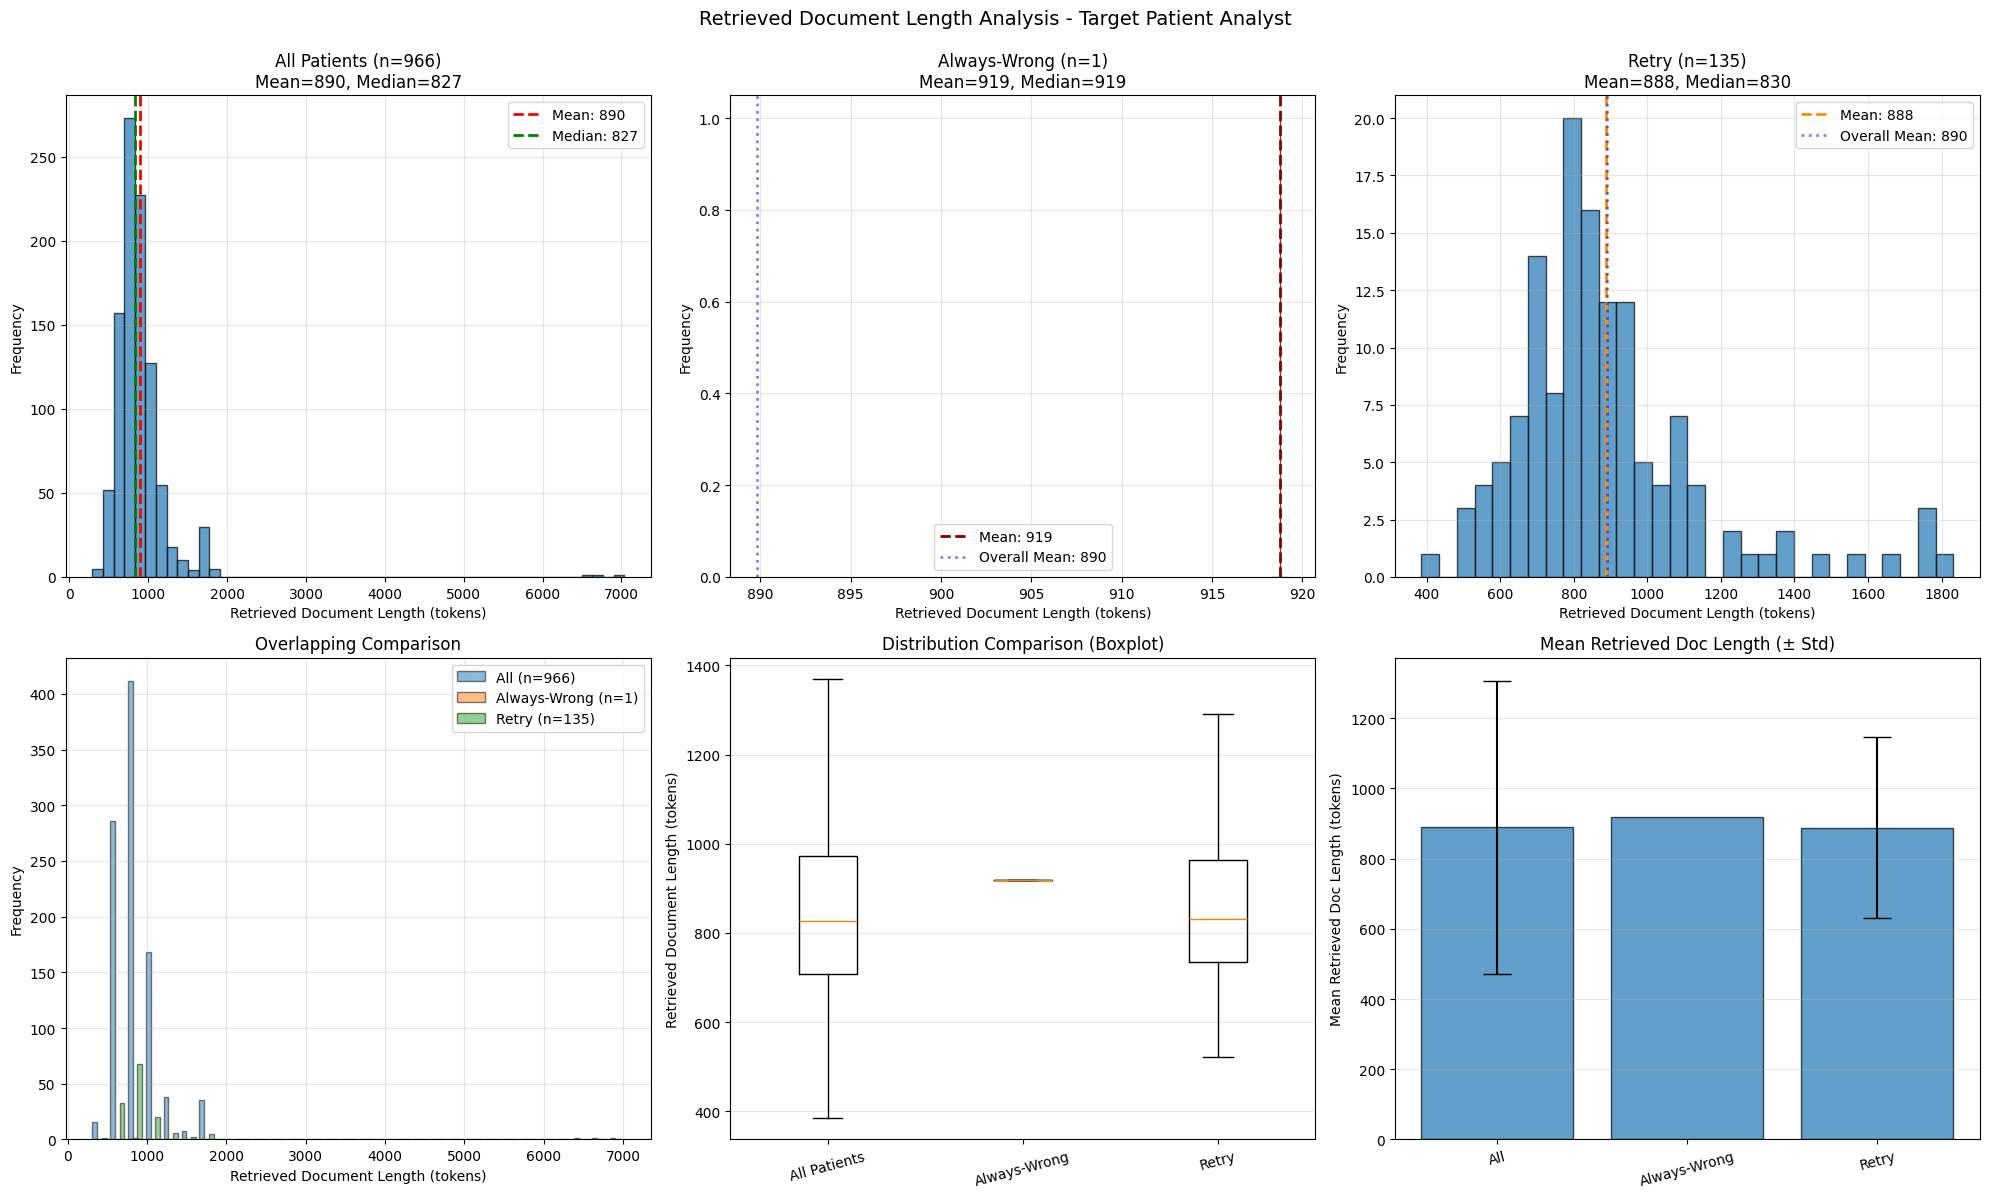


STATISTICS FOR TARGET PATIENT ANALYST

All Patients (n=966):
  Mean: 889.80 tokens
  Median: 826.75 tokens
  Std: 417.44 tokens
  Min: 289, Max: 7036

Always-Wrong (n=1):
  Mean: 918.75 tokens
  Median: 918.75 tokens
  Std: nan tokens
  Min: 919, Max: 919
  Difference from overall mean: +28.95 tokens (+3.25%)

Statistical Test: All vs Always-Wrong (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

Retry (n=135):
  Mean: 887.57 tokens
  Median: 830.50 tokens
  Std: 257.89 tokens
  Min: 386, Max: 1832
  Difference from overall mean: -2.23 tokens (-0.25%)

Statistical Test: All vs Retry (t-test, unequal var not assumed)
  t-statistic: 0.0860
  p-value: 0.9315

Statistical Test: Always-Wrong vs Retry (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

ROLE: Mortality Risk Assessor
Retrieved documents collected:
  All patients: 964
  Always-wrong patients: 1
  Retry patients: 135


/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/tmp/ipykernel_1871161/4176811166.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=box_labels, showfliers=False)


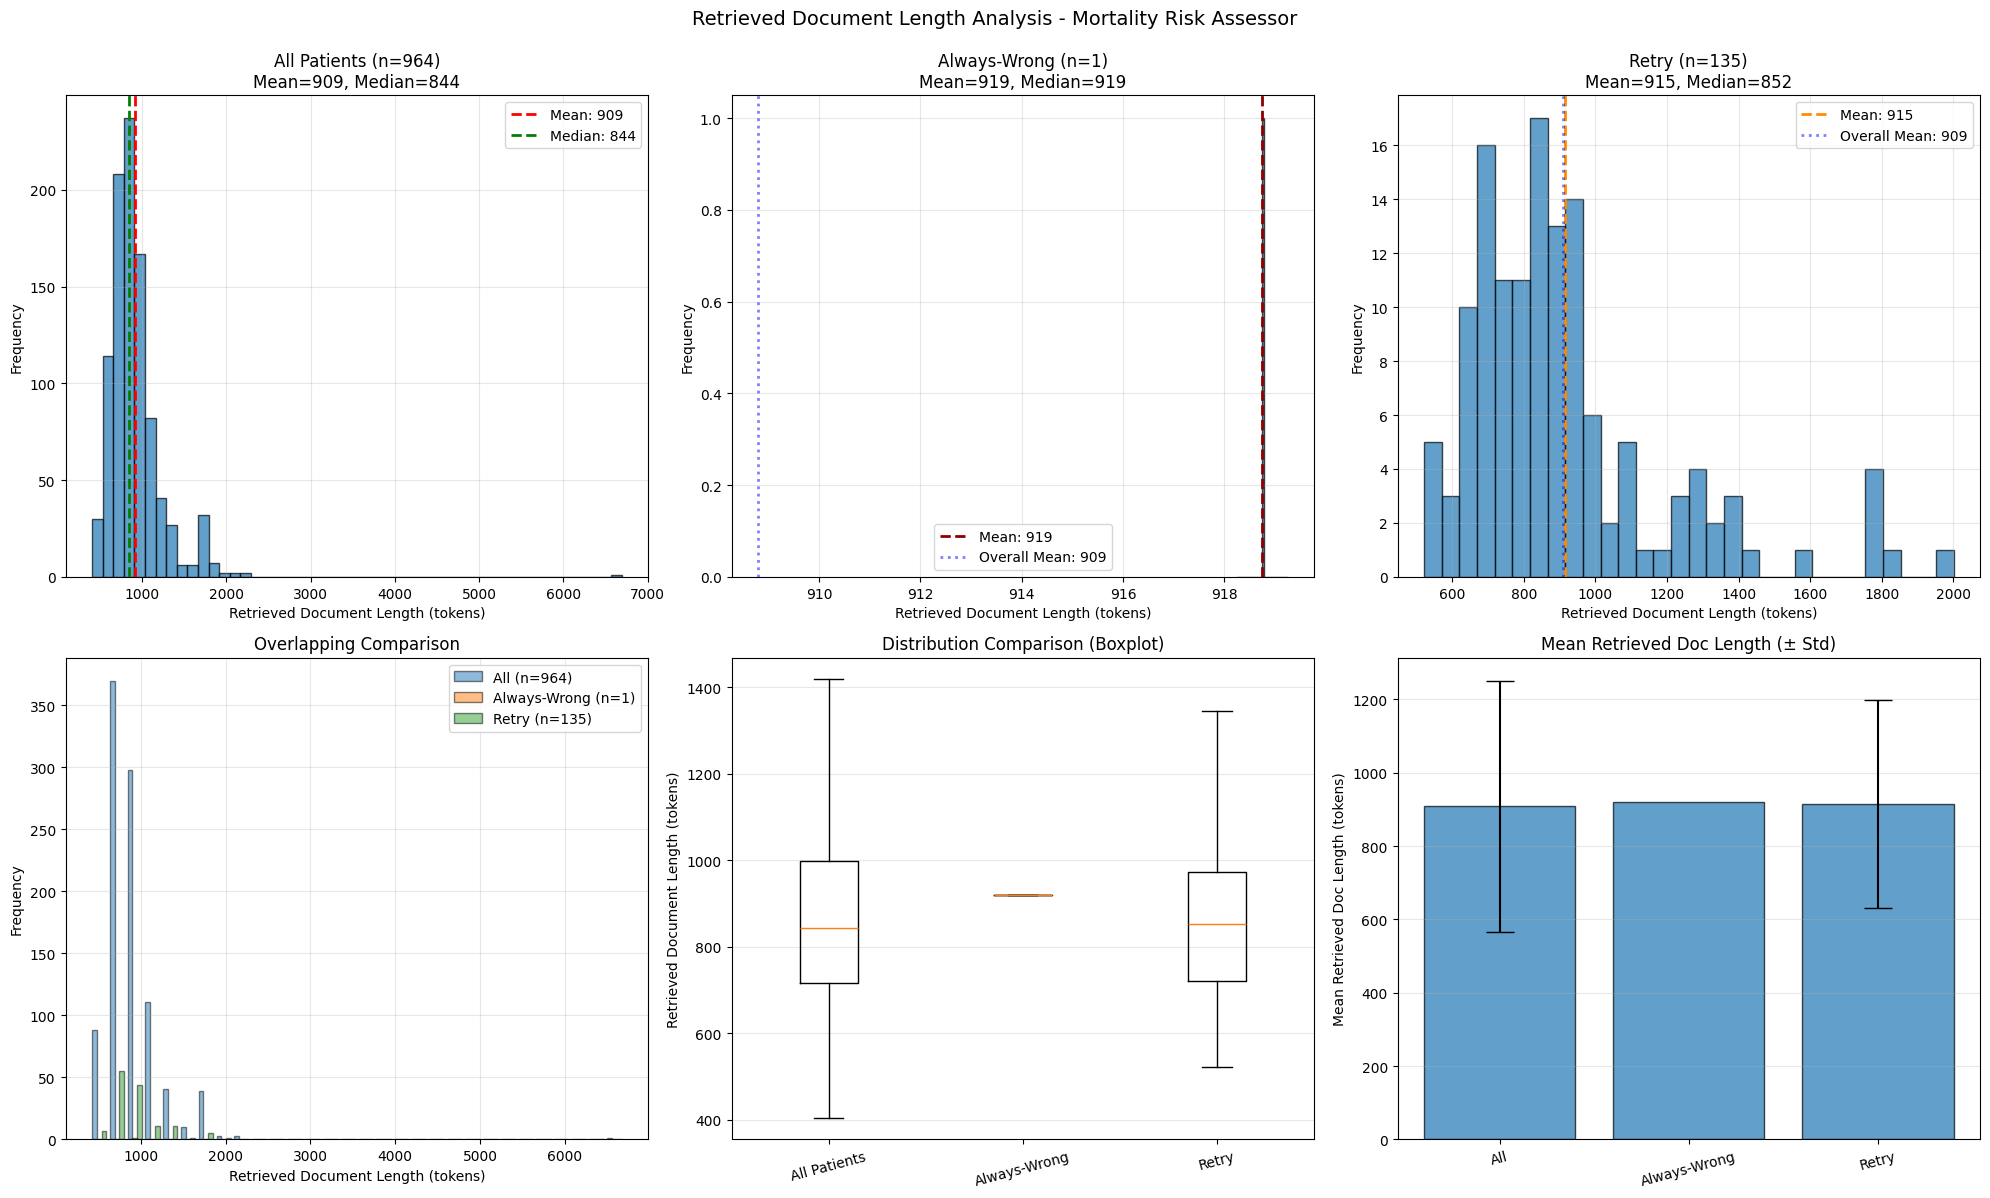


STATISTICS FOR MORTALITY RISK ASSESSOR

All Patients (n=964):
  Mean: 908.80 tokens
  Median: 844.12 tokens
  Std: 342.47 tokens
  Min: 406, Max: 6691

Always-Wrong (n=1):
  Mean: 918.75 tokens
  Median: 918.75 tokens
  Std: nan tokens
  Min: 919, Max: 919
  Difference from overall mean: +9.95 tokens (+1.10%)

Statistical Test: All vs Always-Wrong (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

Retry (n=135):
  Mean: 915.22 tokens
  Median: 852.00 tokens
  Std: 283.70 tokens
  Min: 521, Max: 2000
  Difference from overall mean: +6.42 tokens (+0.71%)

Statistical Test: All vs Retry (t-test, unequal var not assumed)
  t-statistic: -0.2398
  p-value: 0.8108

Statistical Test: Always-Wrong vs Retry (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

ROLE: Protective Factor Analyst
Retrieved documents collected:
  All patients: 964
  Always-wrong patients: 1
  Retry patients: 135


/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/tmp/ipykernel_1871161/4176811166.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=box_labels, showfliers=False)


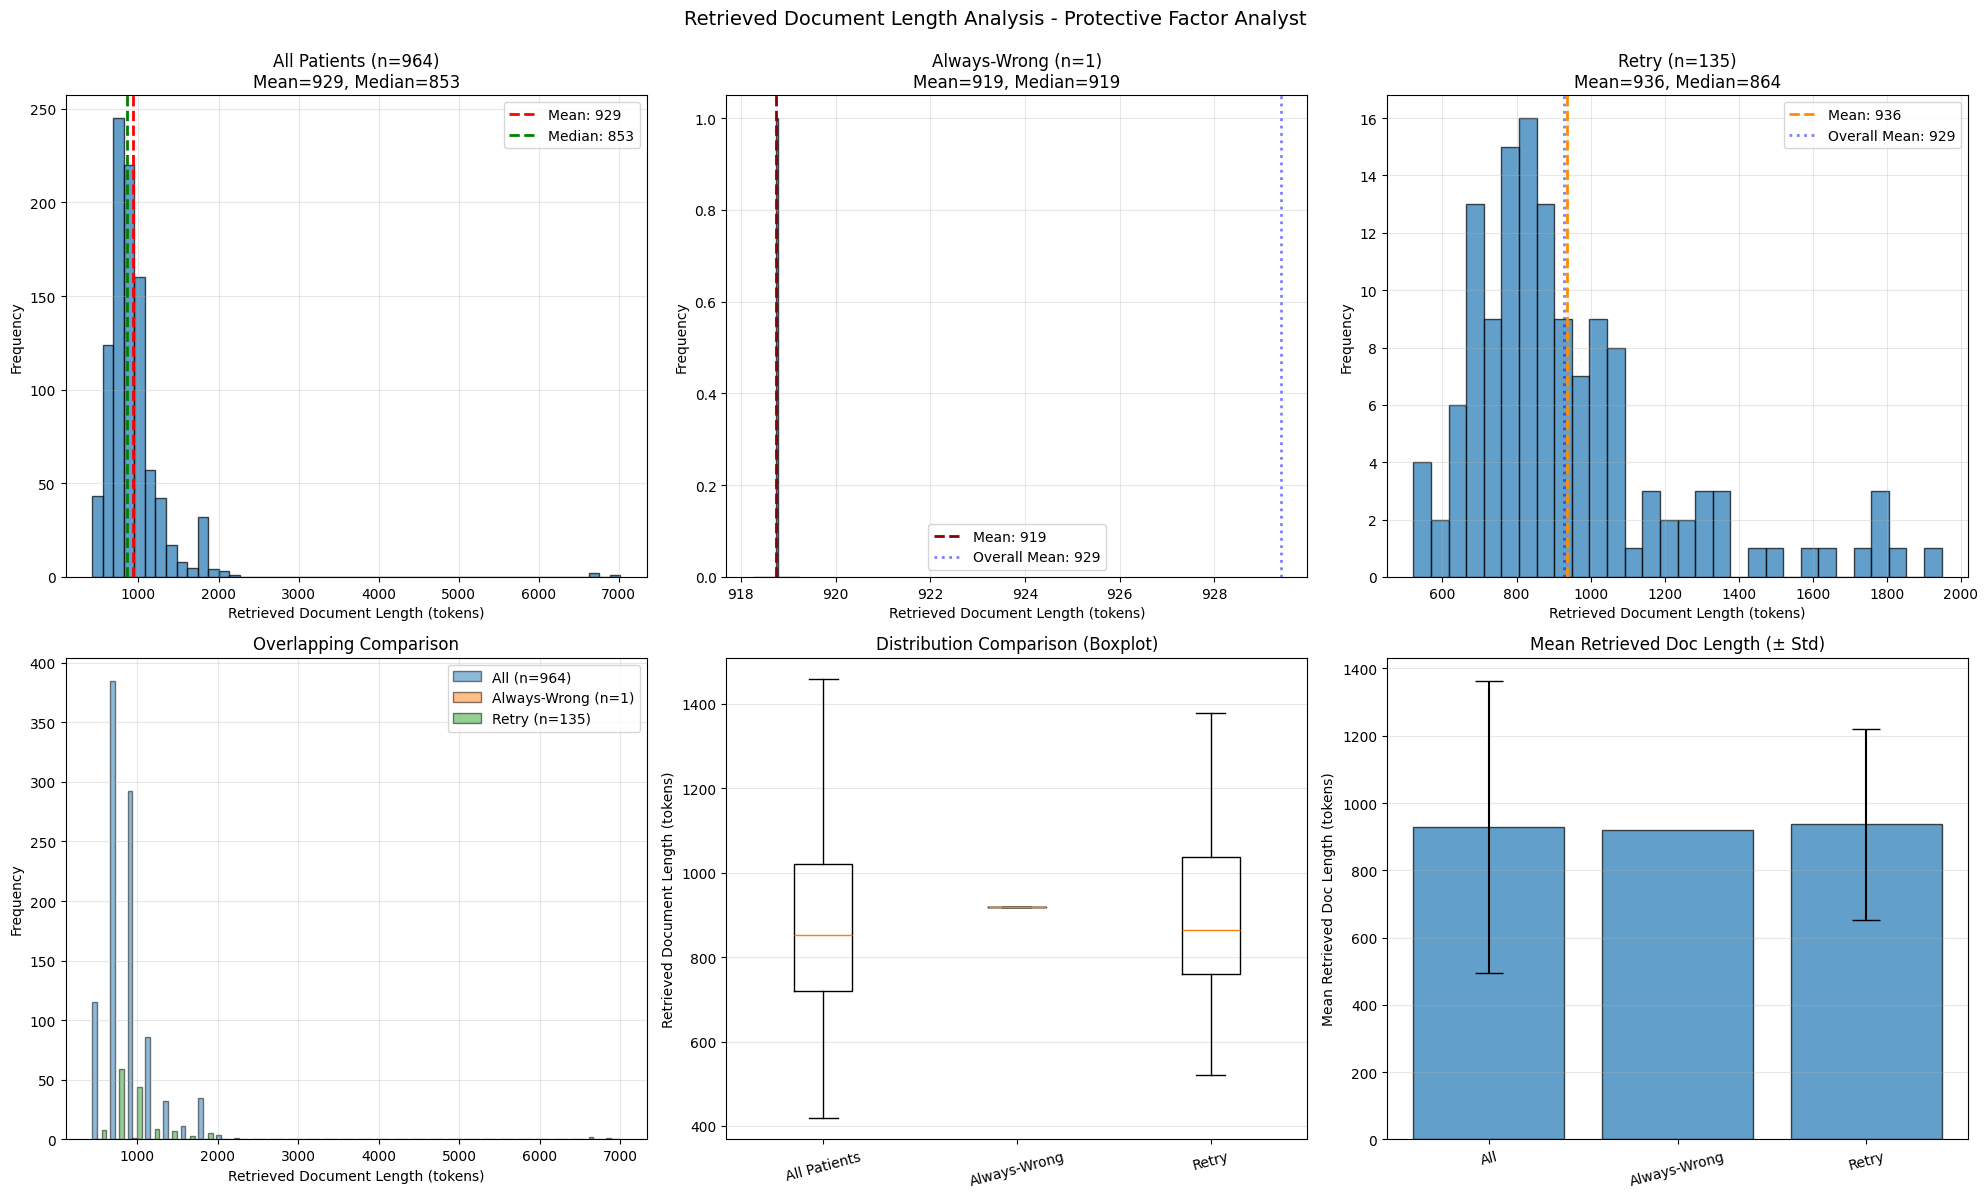


STATISTICS FOR PROTECTIVE FACTOR ANALYST

All Patients (n=964):
  Mean: 929.41 tokens
  Median: 853.12 tokens
  Std: 434.64 tokens
  Min: 420, Max: 7022

Always-Wrong (n=1):
  Mean: 918.75 tokens
  Median: 918.75 tokens
  Std: nan tokens
  Min: 919, Max: 919
  Difference from overall mean: -10.66 tokens (-1.15%)

Statistical Test: All vs Always-Wrong (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

Retry (n=135):
  Mean: 936.39 tokens
  Median: 863.75 tokens
  Std: 284.77 tokens
  Min: 521, Max: 1948
  Difference from overall mean: +6.98 tokens (+0.75%)

Statistical Test: All vs Retry (t-test, unequal var not assumed)
  t-statistic: -0.2472
  p-value: 0.8049

Statistical Test: Always-Wrong vs Retry (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

ROLE: Integrator Mortality
Retrieved documents collected:
  All patients: 953
  Always-wrong patients: 1
  Retry patients: 135


/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/tmp/ipykernel_1871161/4176811166.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=box_labels, showfliers=False)
/tmp/ipykernel_1871161/4176811166.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=box_labels, showfliers=False)


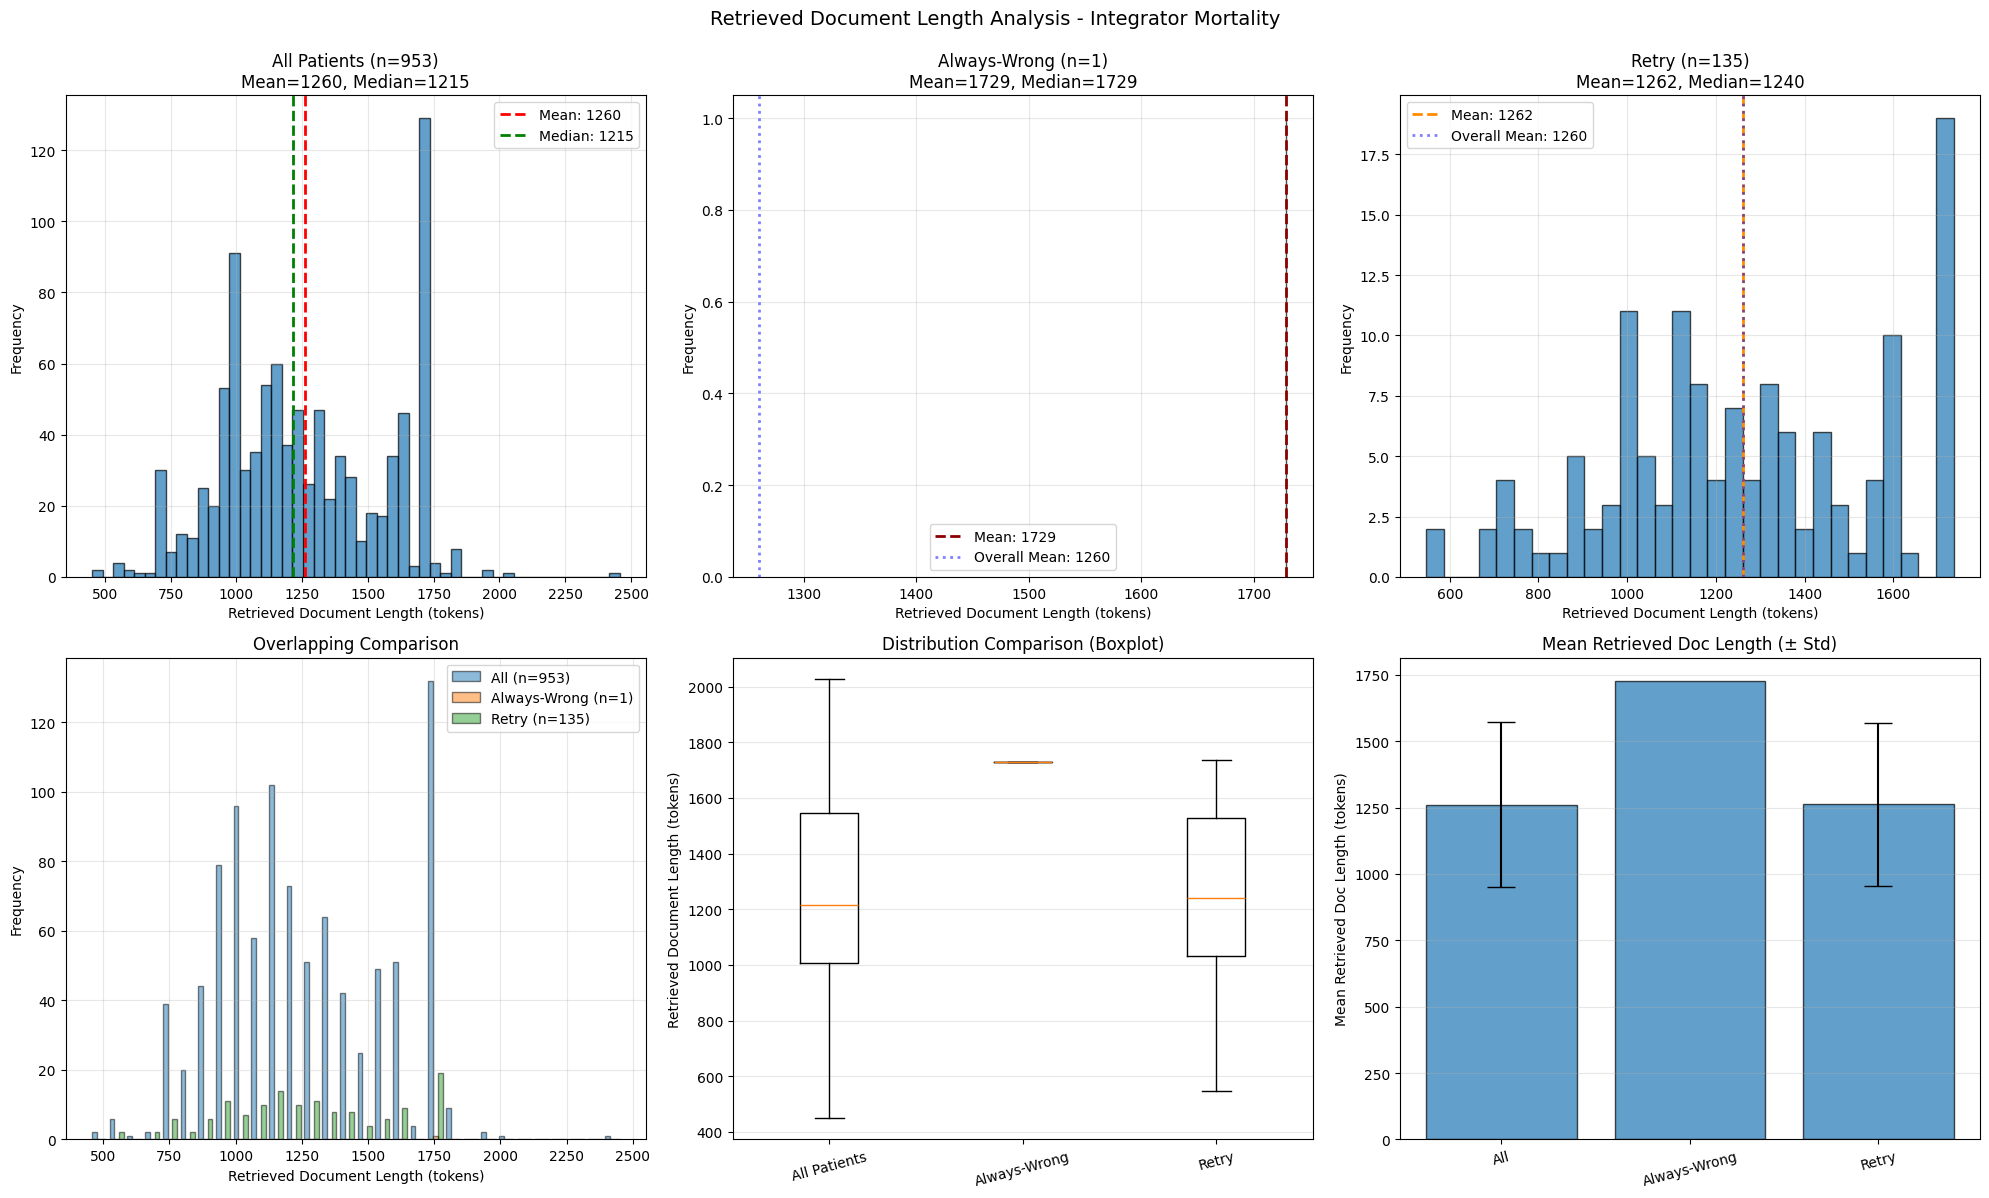


STATISTICS FOR INTEGRATOR MORTALITY

All Patients (n=953):
  Mean: 1260.40 tokens
  Median: 1215.25 tokens
  Std: 310.77 tokens
  Min: 451, Max: 2456

Always-Wrong (n=1):
  Mean: 1728.75 tokens
  Median: 1728.75 tokens
  Std: nan tokens
  Min: 1729, Max: 1729
  Difference from overall mean: +468.35 tokens (+37.16%)

Statistical Test: All vs Always-Wrong (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

Retry (n=135):
  Mean: 1261.84 tokens
  Median: 1240.00 tokens
  Std: 308.14 tokens
  Min: 547, Max: 1736
  Difference from overall mean: +1.44 tokens (+0.11%)

Statistical Test: All vs Retry (t-test, unequal var not assumed)
  t-statistic: -0.0507
  p-value: 0.9596

Statistical Test: Always-Wrong vs Retry (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

ROLE: Integrator Survival
Retrieved documents collected:
  All patients: 935
  Always-wrong patients: 1
  Retry patients: 129


/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/tmp/ipykernel_1871161/4176811166.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=box_labels, showfliers=False)


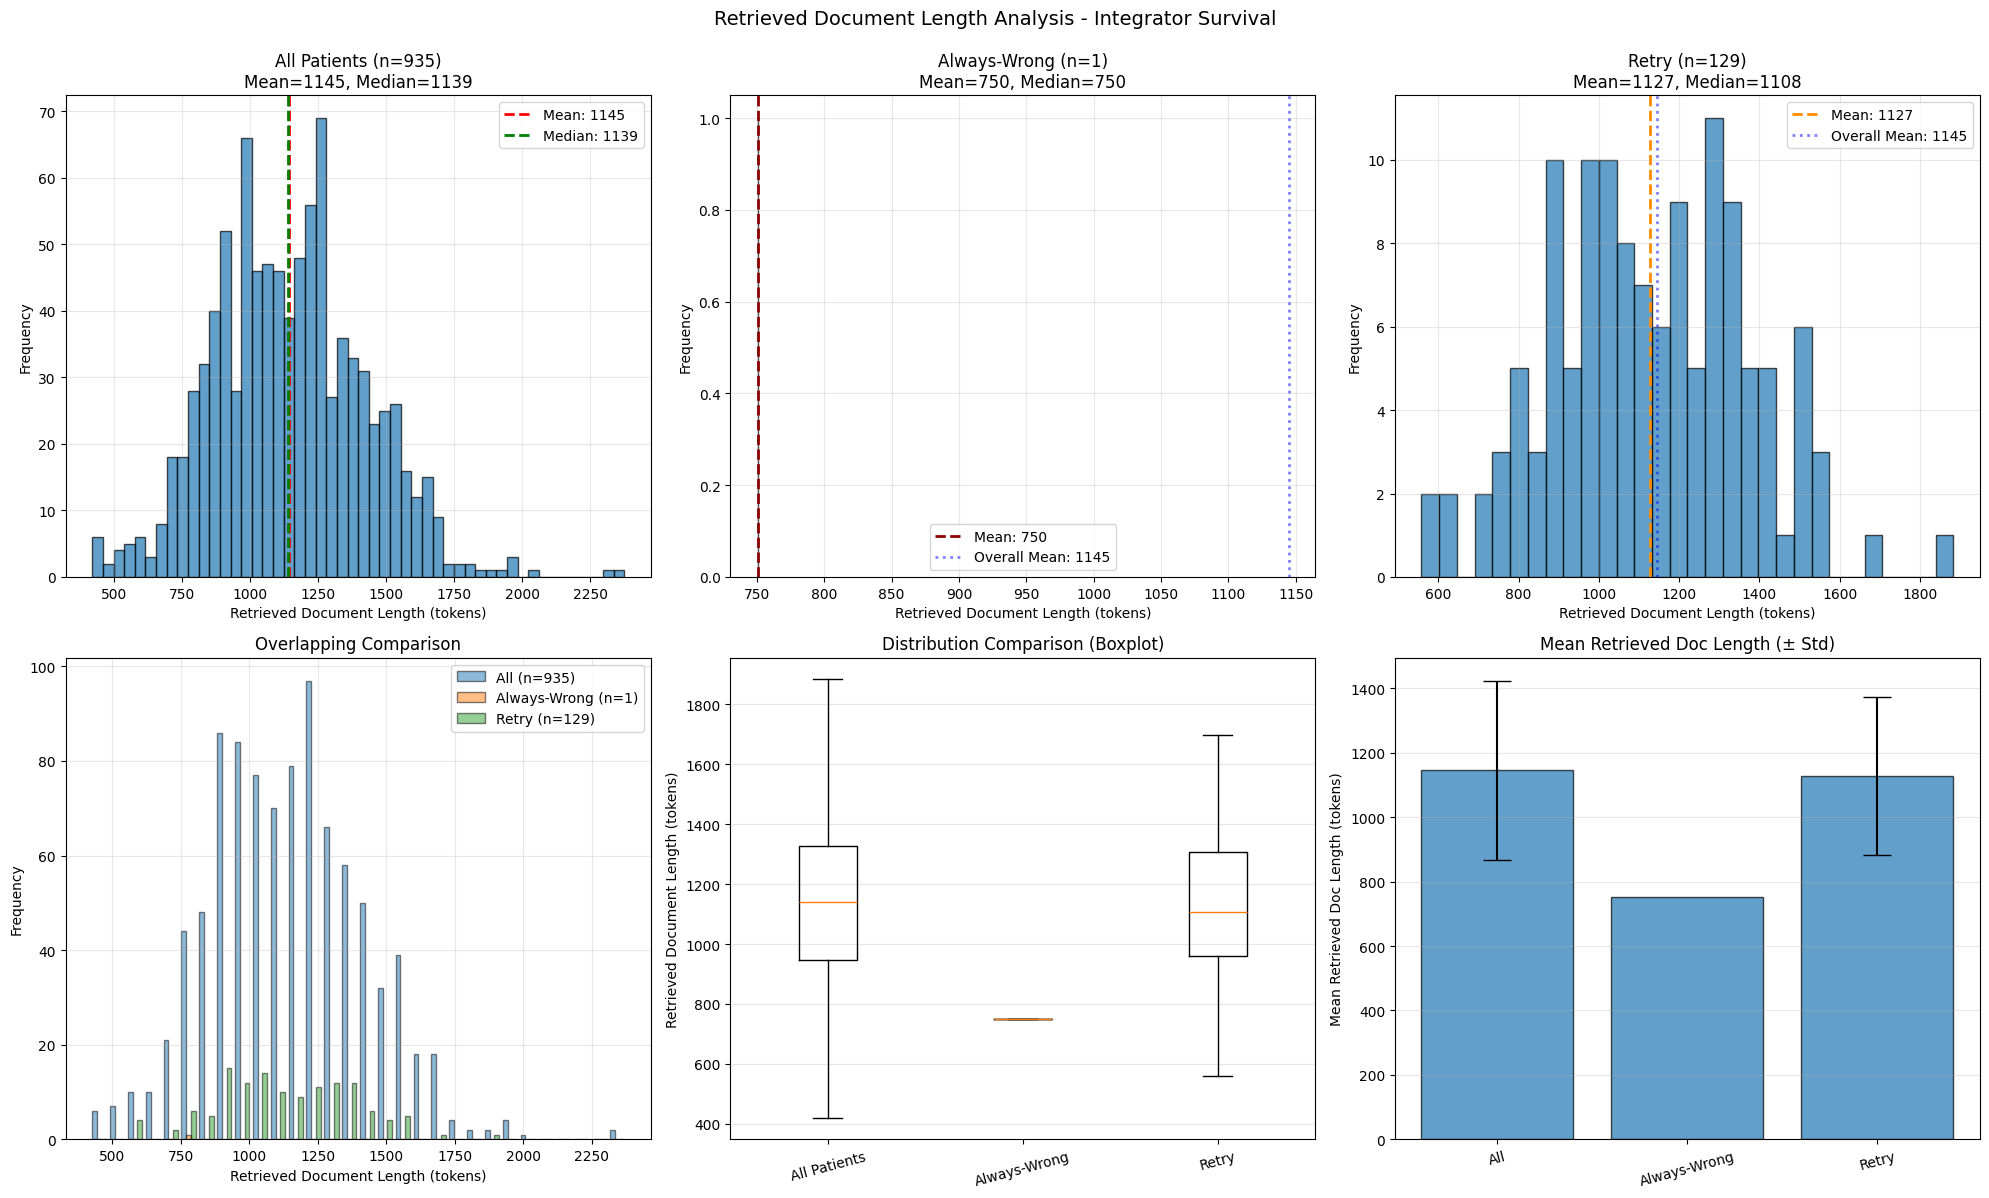


STATISTICS FOR INTEGRATOR SURVIVAL

All Patients (n=935):
  Mean: 1144.89 tokens
  Median: 1139.00 tokens
  Std: 278.66 tokens
  Min: 421, Max: 2374

Always-Wrong (n=1):
  Mean: 750.50 tokens
  Median: 750.50 tokens
  Std: nan tokens
  Min: 750, Max: 750
  Difference from overall mean: -394.39 tokens (-34.45%)

Statistical Test: All vs Always-Wrong (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

Retry (n=129):
  Mean: 1126.90 tokens
  Median: 1108.25 tokens
  Std: 245.83 tokens
  Min: 558, Max: 1883
  Difference from overall mean: -17.99 tokens (-1.57%)

Statistical Test: All vs Retry (t-test, unequal var not assumed)
  t-statistic: 0.7660
  p-value: 0.4447

Statistical Test: Always-Wrong vs Retry (t-test, unequal var not assumed)
  t-statistic: nan
  p-value: nan

CROSS-ROLE COMPARISON SUMMARY
Model: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8

Mean retrieved document lengths (tok

/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/data/wang/junh/envs/kare_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


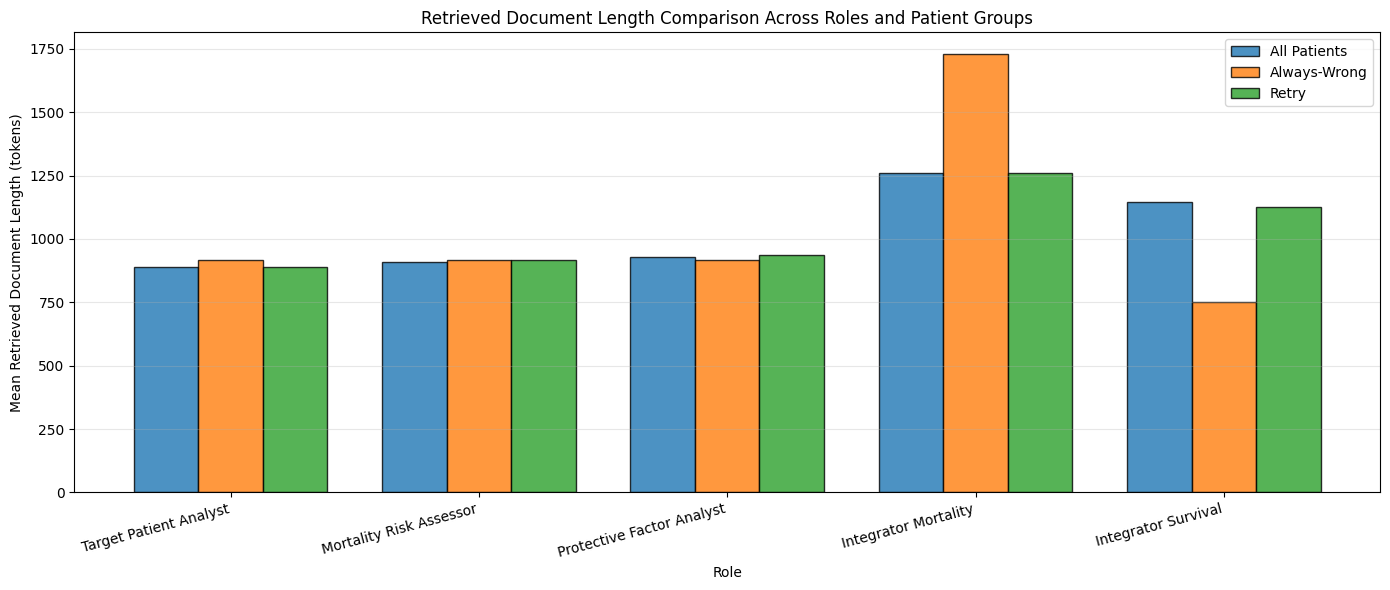

In [36]:
# Analyze retrieved document lengths for each role across patient groups
# Compare 3 groups: all patients, always-wrong patients, retry patients
# Roles (5): target_patient_analyst, mortality_risk_assessor, protective_factor_analyst,
#            integrator_mortality, integrator_survival

import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def extract_retrieved_doc_length(retrieve_file_path):
    """Extract total retrieved document content length from a retrieve JSON file (approx tokens)."""
    try:
        with open(retrieve_file_path, "r", encoding="utf-8", errors="ignore") as f:
            data = json.load(f)

        total_length = 0
        for doc in data.get("retrieved_documents", []):
            content = doc.get("content", "")
            if isinstance(content, str):
                total_length += len(content)

        return total_length / 4.0  # ~4 chars/token
    except Exception:
        return None


# ----------------------------
# ROLES (UPDATED TO 5)
# ----------------------------
roles = [
    "target_patient_analyst",
    "mortality_risk_assessor",
    "protective_factor_analyst",
    "mortality_assessment",
    "survival_assessment",
]

role_names_display = {
    "target_patient_analyst": "Target Patient Analyst",
    "mortality_risk_assessor": "Mortality Risk Assessor",
    "protective_factor_analyst": "Protective Factor Analyst",
    "mortality_assessment": "Integrator Mortality",
    "survival_assessment": "Integrator Survival",
}

# ----------------------------
# TARGET MODEL
# ----------------------------
target_model = "rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8"

print(f"Analyzing retrieved document lengths for model: {target_model}")
print("=" * 80)

model_path = os.path.join(base_path_rag, target_model)
debate_logs_path = os.path.join(model_path, "debate_logs")

if not os.path.isdir(debate_logs_path):
    print(f"ERROR: Model directory not found at {model_path}")
else:
    print(f"Found debate logs at: {debate_logs_path}\n")

    # Initialize storage for this model
    role_lengths = {role: [] for role in roles}

    # Get all retrieve JSON files
    retrieve_files = [f for f in os.listdir(debate_logs_path) if f.startswith("retrieve_") and f.endswith(".json")]
    print(f"Total retrieve files found: {len(retrieve_files)}")

    # Count files per role
    role_file_counts = {role: 0 for role in roles}

    # NOTE: filename format assumed: retrieve_{role}_{patientNumeric}_{visitNumeric}.json
    # e.g. retrieve_target_patient_analyst_10117_0.json  -> patient_id "10117_0"
    filename_re = re.compile(r"retrieve_(.+)_(\d+)_(\d+)\.json$")

    for retrieve_file in retrieve_files:
        m = filename_re.match(retrieve_file)
        if not m:
            continue

        role = m.group(1)
        patient_id = f"{m.group(2)}_{m.group(3)}"

        if role not in roles:
            continue

        role_file_counts[role] += 1
        retrieve_path = os.path.join(debate_logs_path, retrieve_file)
        doc_length = extract_retrieved_doc_length(retrieve_path)

        if doc_length is not None:
            role_lengths[role].append({"patient_id": patient_id, "doc_length": doc_length})

    print("\nRetrieve files per role:")
    for role in roles:
        parsed = len(role_lengths[role])
        print(f"  {role}: {role_file_counts[role]} files, {parsed} successfully parsed")

    # Convert to DataFrames for easier filtering
    role_dfs = {role: pd.DataFrame(v) for role, v in role_lengths.items() if len(v) > 0}

    print("\n" + "=" * 80)
    print("RETRIEVED DOCUMENT LENGTH ANALYSIS BY ROLE AND PATIENT GROUP")
    print(f"Model: {target_model}")
    print("=" * 80)

    # Patient groups (safe guards)
    always_wrong_ids = always_wrong if "always_wrong" in locals() else []
    retry_patient_ids = list(all_retry_patients.keys()) if "all_retry_patients" in locals() else []

    # Total patients analyzed (safe)
    if "patient_data" in locals():
        total_patients = len(patient_data)
    else:
        # fallback: count unique patients seen in any role df
        uniq = set()
        for df in role_dfs.values():
            uniq.update(df["patient_id"].unique().tolist())
        total_patients = len(uniq)

    print(f"\nPatient groups:")
    print(f"  Total patients analyzed: {total_patients}")
    print(f"  Always-wrong patients: {len(always_wrong_ids)}")
    print(f"  Patients with retries: {len(retry_patient_ids)}")

    # ----------------------------
    # PER-ROLE PLOTS
    # ----------------------------
    for role in roles:
        if role not in role_dfs:
            print(f"\n{'=' * 80}")
            print(f"ROLE: {role_names_display[role]}")
            print("=" * 80)
            print("No retrieve data for this role.")
            continue

        role_df = role_dfs[role]

        print(f"\n{'=' * 80}")
        print(f"ROLE: {role_names_display[role]}")
        print("=" * 80)

        all_lengths = role_df["doc_length"]
        always_wrong_lengths = role_df[role_df["patient_id"].isin(always_wrong_ids)]["doc_length"]
        retry_lengths = role_df[role_df["patient_id"].isin(retry_patient_ids)]["doc_length"]

        print("Retrieved documents collected:")
        print(f"  All patients: {len(all_lengths)}")
        print(f"  Always-wrong patients: {len(always_wrong_lengths)}")
        print(f"  Retry patients: {len(retry_lengths)}")

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))

        # Plot 1: All
        axes[0, 0].hist(all_lengths, bins=50, alpha=0.7, edgecolor="black")
        axes[0, 0].set_xlabel("Retrieved Document Length (tokens)")
        axes[0, 0].set_ylabel("Frequency")
        axes[0, 0].set_title(
            f"All Patients (n={len(all_lengths)})\nMean={all_lengths.mean():.0f}, Median={all_lengths.median():.0f}"
        )
        axes[0, 0].axvline(all_lengths.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {all_lengths.mean():.0f}")
        axes[0, 0].axvline(all_lengths.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {all_lengths.median():.0f}")
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Always-wrong
        if len(always_wrong_lengths) > 0:
            axes[0, 1].hist(always_wrong_lengths, bins=30, alpha=0.7, edgecolor="black")
            axes[0, 1].set_xlabel("Retrieved Document Length (tokens)")
            axes[0, 1].set_ylabel("Frequency")
            axes[0, 1].set_title(
                f"Always-Wrong (n={len(always_wrong_lengths)})\nMean={always_wrong_lengths.mean():.0f}, Median={always_wrong_lengths.median():.0f}"
            )
            axes[0, 1].axvline(always_wrong_lengths.mean(), color="darkred", linestyle="--", linewidth=2, label=f"Mean: {always_wrong_lengths.mean():.0f}")
            axes[0, 1].axvline(all_lengths.mean(), color="blue", linestyle=":", linewidth=2, alpha=0.5, label=f"Overall Mean: {all_lengths.mean():.0f}")
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, "No always-wrong patients", ha="center", va="center", transform=axes[0, 1].transAxes)
            axes[0, 1].set_title("Always-Wrong Patients")
            axes[0, 1].set_axis_off()

        # Plot 3: Retry
        if len(retry_lengths) > 0:
            axes[0, 2].hist(retry_lengths, bins=30, alpha=0.7, edgecolor="black")
            axes[0, 2].set_xlabel("Retrieved Document Length (tokens)")
            axes[0, 2].set_ylabel("Frequency")
            axes[0, 2].set_title(
                f"Retry (n={len(retry_lengths)})\nMean={retry_lengths.mean():.0f}, Median={retry_lengths.median():.0f}"
            )
            axes[0, 2].axvline(retry_lengths.mean(), color="darkorange", linestyle="--", linewidth=2, label=f"Mean: {retry_lengths.mean():.0f}")
            axes[0, 2].axvline(all_lengths.mean(), color="blue", linestyle=":", linewidth=2, alpha=0.5, label=f"Overall Mean: {all_lengths.mean():.0f}")
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)
        else:
            axes[0, 2].text(0.5, 0.5, "No retry patients", ha="center", va="center", transform=axes[0, 2].transAxes)
            axes[0, 2].set_title("Patients with Retries")
            axes[0, 2].set_axis_off()

        # Plot 4: Overlapping histograms (only include non-empty groups)
        group_series = [all_lengths]
        group_labels = [f"All (n={len(all_lengths)})"]

        if len(always_wrong_lengths) > 0:
            group_series.append(always_wrong_lengths)
            group_labels.append(f"Always-Wrong (n={len(always_wrong_lengths)})")
        if len(retry_lengths) > 0:
            group_series.append(retry_lengths)
            group_labels.append(f"Retry (n={len(retry_lengths)})")

        axes[1, 0].hist(group_series, bins=30, alpha=0.5, edgecolor="black", label=group_labels)
        axes[1, 0].set_xlabel("Retrieved Document Length (tokens)")
        axes[1, 0].set_ylabel("Frequency")
        axes[1, 0].set_title("Overlapping Comparison")
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 5: Box plot comparison (plot any available groups)
        box_data = [all_lengths]
        box_labels = ["All Patients"]
        if len(always_wrong_lengths) > 0:
            box_data.append(always_wrong_lengths)
            box_labels.append("Always-Wrong")
        if len(retry_lengths) > 0:
            box_data.append(retry_lengths)
            box_labels.append("Retry")

        if len(box_data) >= 2:
            axes[1, 1].boxplot(box_data, labels=box_labels, showfliers=False)
            axes[1, 1].set_ylabel("Retrieved Document Length (tokens)")
            axes[1, 1].set_title("Distribution Comparison (Boxplot)")
            axes[1, 1].grid(True, alpha=0.3, axis="y")
            axes[1, 1].tick_params(axis="x", rotation=15)
        else:
            axes[1, 1].text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=axes[1, 1].transAxes)
            axes[1, 1].set_axis_off()

        # Plot 6: Mean bars with Std (plot any available groups)
        means = [all_lengths.mean()]
        stds = [all_lengths.std()]
        mlabels = ["All"]

        if len(always_wrong_lengths) > 0:
            means.append(always_wrong_lengths.mean())
            stds.append(always_wrong_lengths.std())
            mlabels.append("Always-Wrong")
        if len(retry_lengths) > 0:
            means.append(retry_lengths.mean())
            stds.append(retry_lengths.std())
            mlabels.append("Retry")

        if len(means) >= 2:
            xpos = np.arange(len(means))
            axes[1, 2].bar(xpos, means, yerr=stds, alpha=0.7, edgecolor="black", capsize=10)
            axes[1, 2].set_xticks(xpos)
            axes[1, 2].set_xticklabels(mlabels, rotation=15)
            axes[1, 2].set_ylabel("Mean Retrieved Doc Length (tokens)")
            axes[1, 2].set_title("Mean Retrieved Doc Length (± Std)")
            axes[1, 2].grid(True, alpha=0.3, axis="y")
        else:
            axes[1, 2].text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=axes[1, 2].transAxes)
            axes[1, 2].set_axis_off()

        plt.suptitle(f"Retrieved Document Length Analysis - {role_names_display[role]}", fontsize=14, y=0.995)
        plt.tight_layout()
        plt.show()

        # ----------------------------
        # PRINT STATS + TESTS
        # ----------------------------
        print(f"\nSTATISTICS FOR {role_names_display[role].upper()}")
        print(f"\nAll Patients (n={len(all_lengths)}):")
        print(f"  Mean: {all_lengths.mean():.2f} tokens")
        print(f"  Median: {all_lengths.median():.2f} tokens")
        print(f"  Std: {all_lengths.std():.2f} tokens")
        print(f"  Min: {all_lengths.min():.0f}, Max: {all_lengths.max():.0f}")

        if len(always_wrong_lengths) > 0:
            print(f"\nAlways-Wrong (n={len(always_wrong_lengths)}):")
            print(f"  Mean: {always_wrong_lengths.mean():.2f} tokens")
            print(f"  Median: {always_wrong_lengths.median():.2f} tokens")
            print(f"  Std: {always_wrong_lengths.std():.2f} tokens")
            print(f"  Min: {always_wrong_lengths.min():.0f}, Max: {always_wrong_lengths.max():.0f}")
            if all_lengths.mean() != 0:
                diff = always_wrong_lengths.mean() - all_lengths.mean()
                pct = diff / all_lengths.mean() * 100
                print(f"  Difference from overall mean: {diff:+.2f} tokens ({pct:+.2f}%)")

            print("\nStatistical Test: All vs Always-Wrong (t-test, unequal var not assumed)")
            t_stat, p_value = stats.ttest_ind(all_lengths, always_wrong_lengths, equal_var=False, nan_policy="omit")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")

        if len(retry_lengths) > 0:
            print(f"\nRetry (n={len(retry_lengths)}):")
            print(f"  Mean: {retry_lengths.mean():.2f} tokens")
            print(f"  Median: {retry_lengths.median():.2f} tokens")
            print(f"  Std: {retry_lengths.std():.2f} tokens")
            print(f"  Min: {retry_lengths.min():.0f}, Max: {retry_lengths.max():.0f}")
            if all_lengths.mean() != 0:
                diff = retry_lengths.mean() - all_lengths.mean()
                pct = diff / all_lengths.mean() * 100
                print(f"  Difference from overall mean: {diff:+.2f} tokens ({pct:+.2f}%)")

            print("\nStatistical Test: All vs Retry (t-test, unequal var not assumed)")
            t_stat, p_value = stats.ttest_ind(all_lengths, retry_lengths, equal_var=False, nan_policy="omit")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")

        if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0:
            print("\nStatistical Test: Always-Wrong vs Retry (t-test, unequal var not assumed)")
            t_stat, p_value = stats.ttest_ind(always_wrong_lengths, retry_lengths, equal_var=False, nan_policy="omit")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")

    # ----------------------------
    # CROSS-ROLE SUMMARY (FIXED FOR 5 ROLES)
    # ----------------------------
    print("\n" + "=" * 80)
    print("CROSS-ROLE COMPARISON SUMMARY")
    print(f"Model: {target_model}")
    print("=" * 80)

    summary_data = []
    for role in roles:
        if role not in role_dfs:
            summary_data.append({
                "RoleKey": role,
                "Role": role_names_display[role],
                "All_Mean": np.nan,
                "All_Std": np.nan,
                "AlwaysWrong_Mean": np.nan,
                "AlwaysWrong_Std": np.nan,
                "Retry_Mean": np.nan,
                "Retry_Std": np.nan,
            })
            continue

        df = role_dfs[role]
        all_s = df["doc_length"]
        aw_s = df[df["patient_id"].isin(always_wrong_ids)]["doc_length"]
        rt_s = df[df["patient_id"].isin(retry_patient_ids)]["doc_length"]

        summary_data.append({
            "RoleKey": role,
            "Role": role_names_display[role],
            "All_Mean": all_s.mean(),
            "All_Std": all_s.std(),
            "AlwaysWrong_Mean": aw_s.mean() if len(aw_s) > 0 else np.nan,
            "AlwaysWrong_Std": aw_s.std() if len(aw_s) > 0 else np.nan,
            "Retry_Mean": rt_s.mean() if len(rt_s) > 0 else np.nan,
            "Retry_Std": rt_s.std() if len(rt_s) > 0 else np.nan,
        })

    summary_df = pd.DataFrame(summary_data)

    print("\nMean retrieved document lengths (tokens) by role and patient group:")
    print(summary_df[["Role", "All_Mean", "AlwaysWrong_Mean", "Retry_Mean"]].to_string(index=False))

    # Grouped bar chart: 5 roles x 3 groups (fixed x-axis + label alignment)
    fig, ax = plt.subplots(figsize=(14, 6))

    x = np.arange(len(roles))
    width = 0.26

    all_means = summary_df.set_index("RoleKey").loc[roles, "All_Mean"].values
    aw_means = summary_df.set_index("RoleKey").loc[roles, "AlwaysWrong_Mean"].values
    rt_means = summary_df.set_index("RoleKey").loc[roles, "Retry_Mean"].values

    # Replace NaN with 0 for plotting, but mark as NA on top
    def plot_group(offset, heights, label):
        heights_plot = np.nan_to_num(heights, nan=0.0)
        bars = ax.bar(x + offset, heights_plot, width, label=label, alpha=0.8, edgecolor="black")
        # annotate NA where missing
        for i, h in enumerate(heights):
            if not np.isfinite(h):
                ax.text(x[i] + offset, 0, "NA", ha="center", va="bottom", fontsize=9, rotation=90)
        return bars

    plot_group(-width, all_means, "All Patients")
    plot_group(0.0, aw_means, "Always-Wrong")
    plot_group(+width, rt_means, "Retry")

    ax.set_xlabel("Role")
    ax.set_ylabel("Mean Retrieved Document Length (tokens)")
    ax.set_title("Retrieved Document Length Comparison Across Roles and Patient Groups")
    ax.set_xticks(x)
    ax.set_xticklabels([role_names_display[r] for r in roles], rotation=15, ha="right")
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()


- Patient context length is not what make the error patients be different with the dataset.